# Modeling

In this notebook, I create different types of models that attempt to predict attendance of MLS matches.

Types of models:

1. Linear Regression
2. XGBoost Regression
3. Random Forest Regression
4. K-Nearest Neighbors Regression

### Business Problem

Major League Soccer (MLS) is the top professional soccer league in the United States and Canada. It began play in 1996 and has been a driving force in growing the sport of soccer in the U.S. ever since.

A major source of income for a league and its teams is ticket sales. MLS exists in a crowded sports landscape in which it competes with both other professional sports and college sports. Avoiding competing head-to-head with the National Football League (NFL) is a major reason that MLS starts its season in late February and ends in early December, out of phase with most other soccer leagues worldwide which start in August and end in May.

**The goal of this project is to determine when MLS should hold their matches in order to maximize attendance.** I will use seasons ranging from 2018 to 2023 to perform my analysis, but I will exclude 2020 because almost the entire season was played without fans in attendance due to the COVID-19 pandemic.

I will look at the following factors related to time:

1. Time of day. Matches start as early as noon and as late as 10 pm.
2. Day of the week. Most matches are played on weekends, a fair number are played on Wednesdays, and a smaller number are played on other weekdays.
3. Month. The season starts in February and ends in December, though the regular season ends in October.
4. Year.

I will also look at these factors related to weather:

1. Temperature. I am especially looking to see if especially hot or cold temperatures negatively affect attendance.
2. Rain and snow. I hypothesize that precipitation could reduce attendance.
3. Windspeed.

The models will also incorporate these factors:

1. Regular season vs. playoffs: I expect playoff matches to have higher attendance.
2. Home openers: In data_exploration.ipynb, there was some evidence that home openers tend to have better attendance than average.
3. Rivalry matches: MLS has quite a few rivalries that could help drive fans to attend matches.
4. Matches without a real home team: Each team has a stadium that it uses for its home matches. However, there have been cases where matches had to be held in neutral locations. There is reason to believe these matches have MUCH lower attendance than average.

**Note about the models**

While I am creating regression models that could make predictions of attendance for single matches, the goal of this work is not to use the model to make match-by-match predictions. I expect there to be a lot of variance in attendance that is not related to the factors listed above, making a single prediction somewhat unreliable. Instead, the goal is to look at the way the factors are incorporated into the models to see what is important and how it affects attendance.

In [1]:
import numpy as np
import scipy.stats as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from model_funcs import *

In [2]:
# Read in data
mlsall_df = pd.read_csv('mls_with_weather.csv', index_col=0)
mlsall_df

,round,day,date,local_time,home_team,home_score,away_score,away_team,attendance,stadium,...,snow,cloudcover,windspeed,windgust,rain_sum,snow_sum,date_year,date_month,date_day,home_opener
0,Regular Season,Sat,2018-03-03,13.0,27,0,2,6,26633,BMO Field,...,0.0,1.0,21.6,42.5,0.0,0.00,2018,3,3,1
1,Regular Season,Sat,2018-03-03,14.5,9,4,0,0,20377,BBVA Compass Stadium,...,0.0,40.0,13.6,23.4,0.0,0.00,2018,3,3,1
2,Regular Season,Sun,2018-03-04,14.0,24,0,1,11,40070,CenturyLink Field,...,0.0,27.0,7.2,18.0,0.0,0.00,2018,3,4,1
3,Regular Season,Sun,2018-03-04,15.0,28,2,1,14,27837,BC Place,...,0.0,65.0,7.6,15.5,0.0,0.00,2018,3,4,1
4,Regular Season,Sat,2018-03-03,19.0,20,2,0,16,16452,Talen Energy Stadium,...,0.0,14.0,27.3,61.9,0.0,0.91,2018,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,Regular Season,Sat,2023-10-21,19.0,5,0,1,22,17538,Dick's Sporting Goods Park,...,0.0,18.0,8.7,24.8,0.0,0.00,2023,10,21,0
2281,Regular Season,Sat,2023-10-21,20.0,26,0,2,24,22423,Citypark,...,0.0,0.0,22.4,45.4,0.0,0.00,2023,10,21,0
2282,Regular Season,Sat,2023-10-21,20.0,25,3,1,12,20479,Children's Mercy Park,...,0.0,0.0,14.0,30.2,0.0,0.00,2023,10,21,0
2283,Wild Card Round,Wed,2023-10-25,19.5,18,5,2,2,16074,Red Bull Arena,...,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,25,0


Below, I drop matches for which weather data is missing and the attendance is 0. If the attendance is 0, it either means the information was missing or fans were not allowed due to the pandemic.

In [3]:
# Drop anything with missing data
mlsall_df.dropna(inplace=True)
# Drop matches with attendance=0
mlsall_df.drop(mlsall_df[mlsall_df['attendance']==0].index, inplace=True)
mlsall_df

,round,day,date,local_time,home_team,home_score,away_score,away_team,attendance,stadium,...,snow,cloudcover,windspeed,windgust,rain_sum,snow_sum,date_year,date_month,date_day,home_opener
0,Regular Season,Sat,2018-03-03,13.0,27,0,2,6,26633,BMO Field,...,0.0,1.0,21.6,42.5,0.0,0.00,2018,3,3,1
1,Regular Season,Sat,2018-03-03,14.5,9,4,0,0,20377,BBVA Compass Stadium,...,0.0,40.0,13.6,23.4,0.0,0.00,2018,3,3,1
2,Regular Season,Sun,2018-03-04,14.0,24,0,1,11,40070,CenturyLink Field,...,0.0,27.0,7.2,18.0,0.0,0.00,2018,3,4,1
3,Regular Season,Sun,2018-03-04,15.0,28,2,1,14,27837,BC Place,...,0.0,65.0,7.6,15.5,0.0,0.00,2018,3,4,1
4,Regular Season,Sat,2018-03-03,19.0,20,2,0,16,16452,Talen Energy Stadium,...,0.0,14.0,27.3,61.9,0.0,0.91,2018,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Regular Season,Sat,2023-10-21,18.0,21,1,3,9,25218,Providence Park,...,0.0,100.0,3.2,14.0,0.0,0.00,2023,10,21,0
2279,Regular Season,Sat,2023-10-21,18.0,28,1,1,11,25146,BC Place Stadium,...,0.0,93.0,4.4,11.9,0.0,0.00,2023,10,21,0
2280,Regular Season,Sat,2023-10-21,19.0,5,0,1,22,17538,Dick's Sporting Goods Park,...,0.0,18.0,8.7,24.8,0.0,0.00,2023,10,21,0
2281,Regular Season,Sat,2023-10-21,20.0,26,0,2,24,22423,Citypark,...,0.0,0.0,22.4,45.4,0.0,0.00,2023,10,21,0


After dropping no weather, no attendance matches, there are 2229 matches remaining.

In [4]:
# Get data types of each column
mlsall_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2282
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   round             2229 non-null   object 
 1   day               2229 non-null   object 
 2   date              2229 non-null   object 
 3   local_time        2229 non-null   float64
 4   home_team         2229 non-null   int64  
 5   home_score        2229 non-null   int64  
 6   away_score        2229 non-null   int64  
 7   away_team         2229 non-null   int64  
 8   attendance        2229 non-null   int64  
 9   stadium           2229 non-null   object 
 10  latitude          2229 non-null   float64
 11  longitude         2229 non-null   float64
 12  playoff           2229 non-null   int64  
 13  att_div_capacity  2229 non-null   float64
 14  real_home_team    2229 non-null   int64  
 15  same_conf         2229 non-null   int64  
 16  rivals            2229 non-null   int64  
 17  

**Target variable**

There are two options for the target variable: attendance and attendance/capacity. I plan on using home team and away team as categorical parameters in the model, so even if I choose to use raw attendance, there will be parameters that effectively normalize the attendance per team. Therefore, I will use raw attendance as the target variable.

In [5]:
# Target variable
#y = mlsall_df['att_div_capacity']
y = mlsall_df['attendance']

### Linear Regression

The way I am going to create the linear regression model is by iteratively trying different combinations of inputs and evaluating the success of the model based on the RMSE of the residuals and the R-squared of the fit.

**Model 1**

To start, I will just fit a single constant to the data.

In [6]:
X = create_X(mlsall_df, columns=[], add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 26 Nov 2023   Prob (F-statistic):                nan
Time:                        12:49:22   Log-Likelihood:                -23554.
No. Observations:                2229   AIC:                         4.711e+04
Df Residuals:                    2228   BIC:                         4.712e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.082e+04    199.049    104.579      0.000    2.04e+04    2.12e+04
==============================================================================
Omnibus:                     1176.355   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9640.591
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                      12.019   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RMSE of residuals: 9397.534829728174
R-squared: 1.1102230246251565e-16


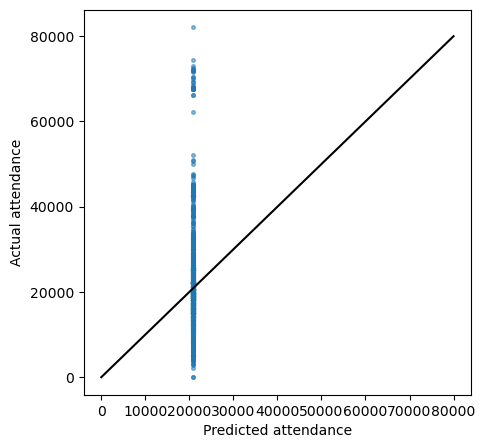

In [7]:
evaluate_linear_model(linreg, X, y)

This model predicts 20,816 for each match. Not surprisingly, this is a pretty bad fit as it does not account for any of the trends in the data.

The RMSE for this fit was 9,398. The goal of subsequent models will be to reduce this number.

**Model 2**

This model will add home and away team parameters. I expect this to improve the fit quite a lot because it will account for differences in stadium capacities.

In [8]:
X = create_X(mlsall_df, columns=['home_team','away_team'], add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     75.95
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:49:23   Log-Likelihood:                -22345.
No. Observations:                2229   AIC:                         4.480e+04
Df Residuals:                    2172   BIC:                         4.513e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.969e+04    845.914     58.746      0.000     4.8e+04    5.14e+04
home_team_1  -2.913e+04    972.269    -29.963      0.000    -3.1e+04   -2.72e+04
home_team_2  -1.374e+04   1114.164    -12.335      0.000   -1.59e+04   -1.16e+04
home_team_3  -3.526e+04    836.884    -42.134      0.000   -3.69e+04   -3.36e+04
home_team_4  -2.557e+04    889.326    -28.756      0.000   -2.73e+04   -2.38e+04
home_team_5  -3.545e+04    856.805    -41.371      0.000   -3.71e+04   -3.38e+04
home_team_6  -3.303e+04    834.050    -39.598      0.000   -3.47e+04   -3.14e+04
home_team_7  -3.411e+04    844.053    -40.408      0.000   -3.58e+04   -3.25e+04
home_team_8  -3.335e+04    834.487    -39.961      0.000    -3.5e+04   -3.17e+04
home_team_9  -3.454e+04    849.717    -40.649      0.000   -3.62e+04   -3.29e+04
home_team_10 -2.754e+04    847.290    -32.506      0.000   -2.92e+04   -2.59e+04
home_team_11 -2.823e+04    835.679    -33.782      0.000   -2.99e+04   -2.66e+04
home_team_12 -3.017e+04    846.290    -35.652      0.000   -3.18e+04   -2.85e+04
home_team_13 -3.491e+04    976.406    -35.759      0.000   -3.68e+04    -3.3e+04
home_team_14 -3.263e+04    878.557    -37.144      0.000   -3.44e+04   -3.09e+04
home_team_15 -2.466e+04    964.828    -25.561      0.000   -2.66e+04   -2.28e+04
home_team_16 -2.992e+04    844.586    -35.427      0.000   -3.16e+04   -2.83e+04
home_team_17 -3.123e+04    830.212    -37.622      0.000   -3.29e+04   -2.96e+04
home_team_18 -3.224e+04    840.056    -38.383      0.000   -3.39e+04   -3.06e+04
home_team_19 -2.989e+04    837.533    -35.684      0.000   -3.15e+04   -2.82e+04
home_team_20 -3.282e+04    822.587    -39.898      0.000   -3.44e+04   -3.12e+04
home_team_21 -2.672e+04    849.975    -31.431      0.000   -2.84e+04    -2.5e+04
home_team_22 -3.152e+04    844.718    -37.310      0.000   -3.32e+04   -2.99e+04
home_team_23 -3.276e+04    859.955    -38.097      0.000   -3.44e+04   -3.11e+04
home_team_24 -1.493e+04    838.042    -17.811      0.000   -1.66e+04   -1.33e+04
home_team_25 -3.083e+04    847.915    -36.360      0.000   -3.25e+04   -2.92e+04
home_team_26 -2.742e+04   1474.258    -18.598      0.000   -3.03e+04   -2.45e+04
home_team_27 -2.679e+04    845.206    -31.691      0.000   -2.84e+04   -2.51e+04
home_team_28 -3.195e+04    867.993    -36.814      0.000   -3.37e+04   -3.03e+04
away_team_1  -1344.9175   1000.817     -1.344      0.179   -3307.576     617.741
away_team_2    452.9537   1135.263      0.399      0.690   -1773.361    2679.268
away_team_3     25.1099    853.860      0.029      0.977   -1649.357    1699.577
away_team_4   -543.4853    908.364     -0.598      0.550   -2324.839    1237.869
away_team_5   -898.9510    863.621     -1.041      0.298   -2592.561     794.658
away_team_6    -62.3314    851.065     -0.073      0.942   -1731.317    1606.655
away_

RMSE of residuals: 5533.834547035362
R-squared: 0.6619592263521832


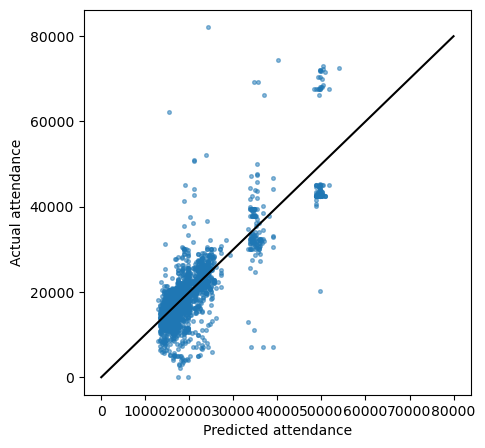

In [9]:
evaluate_linear_model(linreg, X, y)

Accounting for the teams involved in the match improved the fit. The RMSE of the residuals dropped from 9,398 to 5,534.

The R-squared is now at 0.662. The parameters for home and away team will be kept for all subsequent models.

For note, the constant in the fit (49,694) is a lot higher than it was for model 1. This is because the new variables are all in reference to Atlanta United which has the highest average attendance for its home matches. This does strangely mean that the constant assumes a match between Atlanta and Atlanta, but that is not actually a problem.

**Model 3**

In this model, I incorporate a few time-based parameters:
1. Day of the week
2. Month (reference case is a match in July)
3. Local time of kick off (categorical)
4. Year (2018 is reference case)

In [10]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','local_time','date_year'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     82.59
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:49:24   Log-Likelihood:                -22102.
No. Observations:                2229   AIC:                         4.435e+04
Df Residuals:                    2158   BIC:                         4.475e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       543.4748     49.962     10.878      0.000     445.495     641.454
const           5.154e+04    900.852     57.217      0.000    4.98e+04    5.33e+04
home_team_1    -2.782e+04    897.522    -30.995      0.000   -2.96e+04   -2.61e+04
home_team_2    -1.407e+04   1017.085    -13.833      0.000   -1.61e+04   -1.21e+04
home_team_3    -3.478e+04    759.468    -45.797      0.000   -3.63e+04   -3.33e+04
home_team_4    -2.504e+04    809.501    -30.935      0.000   -2.66e+04   -2.35e+04
home_team_5    -3.543e+04    777.777    -45.547      0.000    -3.7e+04   -3.39e+04
home_team_6    -3.283e+04    757.503    -43.337      0.000   -3.43e+04   -3.13e+04
home_team_7    -3.392e+04    766.275    -44.272      0.000   -3.54e+04   -3.24e+04
home_team_8    -3.306e+04    762.564    -43.358      0.000   -3.46e+04   -3.16e+04
home_team_9    -3.422e+04    771.749    -44.338      0.000   -3.57e+04   -3.27e+04
home_team_10   -2.729e+04    769.556    -35.465      0.000   -2.88e+04   -2.58e+04
home_team_11   -2.795e+04    759.683    -36.791      0.000   -2.94e+04   -2.65e+04
home_team_12   -3.004e+04    765.657    -39.232      0.000   -3.15e+04   -2.85e+04
home_team_13   -3.343e+04    897.698    -37.244      0.000   -3.52e+04   -3.17e+04
home_team_14   -3.353e+04    797.633    -42.038      0.000   -3.51e+04    -3.2e+04
home_team_15   -2.333e+04    878.396    -26.565      0.000   -2.51e+04   -2.16e+04
home_team_16    -2.98e+04    767.865    -38.806      0.000   -3.13e+04   -2.83e+04
home_team_17   -3.093e+04    752.882    -41.079      0.000   -3.24e+04   -2.95e+04
home_team_18   -3.231e+04    761.740    -42.410      0.000   -3.38e+04   -3.08e+04
home_team_19    -2.96e+04    759.055    -38.999      0.000   -3.11e+04   -2.81e+04
home_team_20   -3.254e+04    744.693    -43.697      0.000    -3.4e+04   -3.11e+04
home_team_21   -2.691e+04    770.191    -34.940      0.000   -2.84e+04   -2.54e+04
home_team_22   -3.126e+04    775.683    -40.301      0.000   -3.28e+04   -2.97e+04
home_team_23   -3.274e+04    780.229    -41.967      0.000   -3.43e+04   -3.12e+04
home_team_24   -1.463e+04    767.928    -19.051      0.000   -1.61e+04   -1.31e+04
home_team_25   -3.084e+04    766.495    -40.230      0.000   -3.23e+04   -2.93e+04
home_team_26   -2.827e+04   1348.376    -20.963      0.000   -3.09e+04   -2.56e+04
home_team_27   -2.681e+04    766.241    -34.986      0.000   -2.83e+04   -2.53e+04
home_team_28   -3.221e+04    786.050    -40.971      0.000   -3.37e+04   -3.07e+04
away_team_1     -623.9779    908.954     -0.686      0.492   -2406.495    1158.539
away_team_2     -159.2121   1033.821     -0.154      0.878   -2186.601    1868.177
away_team_3      -95.9110    771.111     -0.124      0.901   -1608.110    1416.288
away_team_4     -403.8202    823.049     -0.491      0.624   -2017.872    1210.232
away_team_5 

RMSE of residuals: 4978.200192318331
R-squared: 0.7281977294597555


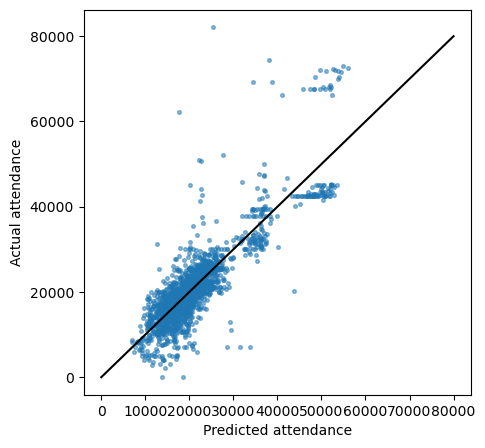

In [11]:
evaluate_linear_model(linreg, X, y)

The fit improved a bit. The R-squared is now 0.728 and the RMSE is 4,978.

Day of the week: All of the parameters for day of the week were negative, indicating that Saturday is the best day to hold matches. However, only Tuesday and Wednesday had p-values below 0.05. The result for Wednesday is quite telling. MLS holds a lot of matches on Wednesdays, but the model here indicates that those matches expect over 3000 fewer attendees than on Saturdays.

Month: The one month parameter is statistically significant according to the p-value. The value of the parameter is 543, which means that attendance goes up by 543 people on average for every month that goes by. That is a significant increase for a season that spans 11 months. However, this number might be biased high because the model does not yet account for the effect of playoff matches which happen at the end of the season. Once that is incorporated into the model, I expect the value of the month parameter to decrease a bit.

Kick off time: None of the parameters were statistically significant at the 0.05 level. The numbers indicate that matches played between 2 and 5 did the best. It is important to keep in mind that almost all of the matches like this were played on the weekend.

Year: Both 2021 and 2022 had significantly lower attendance than 2018. The effect of the pandemic was quite clear in 2021 when the average attendance was about 6000 lower than it was in 2018.

**Model 4**

This model incorporates a few binary factors:

1. Playoff or not
2. Home opener or not
3. Rivals or not
4. Real home team or not

For now, I am going to keep all of the parameters from Model 3, but I am going to keep my eye on the local_time variables to see if they are significant or not.

In [12]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','local_time','date_year',
                      'playoff','home_opener','rivals','real_home_team'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     82.30
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:49:24   Log-Likelihood:                -22058.
No. Observations:                2229   AIC:                         4.427e+04
Df Residuals:                    2154   BIC:                         4.469e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       581.6798     55.051     10.566      0.000     473.722     689.638
playoff         1269.8481    730.027      1.739      0.082    -161.783    2701.479
home_opener     2207.1865    504.476      4.375      0.000    1217.875    3196.498
rivals          2262.3623    401.766      5.631      0.000    1474.472    3050.252
real_home_team  7093.8439   1274.945      5.564      0.000    4593.593    9594.095
const           4.435e+04   1550.084     28.614      0.000    4.13e+04    4.74e+04
home_team_1     -2.82e+04    882.579    -31.949      0.000   -2.99e+04   -2.65e+04
home_team_2    -1.404e+04    998.858    -14.052      0.000    -1.6e+04   -1.21e+04
home_team_3    -3.481e+04    746.347    -46.636      0.000   -3.63e+04   -3.33e+04
home_team_4     -2.52e+04    795.933    -31.666      0.000   -2.68e+04   -2.36e+04
home_team_5    -3.551e+04    764.461    -46.453      0.000    -3.7e+04    -3.4e+04
home_team_6    -3.307e+04    745.182    -44.376      0.000   -3.45e+04   -3.16e+04
home_team_7    -3.415e+04    753.652    -45.310      0.000   -3.56e+04   -3.27e+04
home_team_8    -3.327e+04    750.141    -44.355      0.000   -3.47e+04   -3.18e+04
home_team_9    -3.444e+04    759.610    -45.340      0.000   -3.59e+04    -3.3e+04
home_team_10   -2.751e+04    758.328    -36.275      0.000    -2.9e+04    -2.6e+04
home_team_11   -2.776e+04    748.284    -37.101      0.000   -2.92e+04   -2.63e+04
home_team_12   -2.996e+04    752.285    -39.825      0.000   -3.14e+04   -2.85e+04
home_team_13   -3.361e+04    882.228    -38.092      0.000   -3.53e+04   -3.19e+04
home_team_14   -3.371e+04    783.995    -42.999      0.000   -3.52e+04   -3.22e+04
home_team_15   -2.334e+04    862.532    -27.060      0.000    -2.5e+04   -2.16e+04
home_team_16   -2.978e+04    754.092    -39.497      0.000   -3.13e+04   -2.83e+04
home_team_17   -3.016e+04    758.585    -39.761      0.000   -3.16e+04   -2.87e+04
home_team_18   -3.263e+04    749.797    -43.518      0.000   -3.41e+04   -3.12e+04
home_team_19   -2.967e+04    746.311    -39.758      0.000   -3.11e+04   -2.82e+04
home_team_20   -3.259e+04    730.875    -44.590      0.000    -3.4e+04   -3.12e+04
home_team_21   -2.725e+04    757.851    -35.959      0.000   -2.87e+04   -2.58e+04
home_team_22   -3.143e+04    762.012    -41.241      0.000   -3.29e+04   -2.99e+04
home_team_23   -3.299e+04    768.387    -42.933      0.000   -3.45e+04   -3.15e+04
home_team_24   -1.508e+04    757.364    -19.905      0.000   -1.66e+04   -1.36e+04
home_team_25    -3.08e+04    752.331    -40.944      0.000   -3.23e+04   -2.93e+04
home_team_26   -2.848e+04   1323.878    -21.511      0.000   -3.11e+04   -2.59e+04
home_team_27   -2.704e+04    753.858    -35.864      0.000   -2.85e+04   -2.56e+04
home_team_28    -3.24e+04    773.905    -41.862      0.000   -3.39e+04   -3.09e+04
away_team_1 

RMSE of residuals: 4885.263804900885
R-squared: 0.7387365449922851


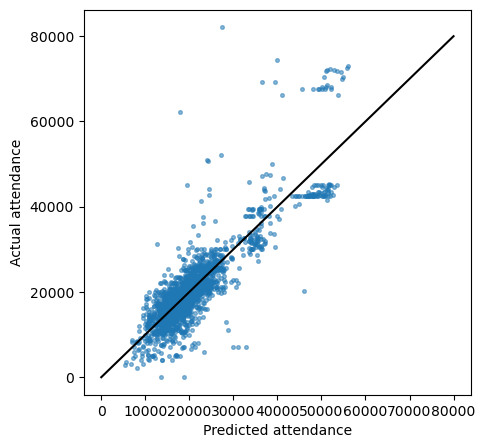

In [13]:
evaluate_linear_model(linreg, X, y)

The fit improved slightly. The R-squared is up to 0.739 and the RMSE is down to 4,885.

Playoff: I was surprised that the parameter for indicating whether a match was a playoff match was not significant at the 0.05 level.

Home openers: The parameter for home openers was significant and it indicates that home openers attract about 2,200 more people than would otherwise be expected.

Rivals: This parameter was also significant. Rivalry matches attract about 2,300 more people on average. Certain teams in MLS don't have rivalries, yet. Can we get Minnesota and Nashville to hate each other?

Real home team: Matches in which the home team was actually the home team averaged nearly 7,100 more fans.

The parameter for month is actually higher now (582).

Wednesdays and Thursdays are both statistically worse than Saturdays for attendance and the effect is quite large. Both get over 2000 fewer people per match.

None of the parameters for kick off time are significant still.

**Model 5**

This model will incorporate weather parameters

1. Whether it rained prior to match or at start of match.
2. Whether it snowed prior to match or at start of match.
3. Whether it was below 40 degrees Fahrenheit.
4. Whether it was above 90 degrees Fahrenheit.
5. Windspeed.

In [14]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','local_time','date_year',
                      'playoff','home_opener','rivals','real_home_team',
                      'rain','snow','temperature','windspeed'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     77.02
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:49:25   Log-Likelihood:                -22057.
No. Observations:                2229   AIC:                         4.427e+04
Df Residuals:                    2149   BIC:                         4.473e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       572.1905     56.687     10.094      0.000     461.023     683.358
playoff         1366.7481    740.555      1.846      0.065     -85.530    2819.026
home_opener     2358.1192    534.832      4.409      0.000    1309.276    3406.962
rivals          2266.5430    403.378      5.619      0.000    1475.490    3057.596
real_home_team  7104.7396   1282.425      5.540      0.000    4589.817    9619.662
windspeed         -4.5852     18.480     -0.248      0.804     -40.826      31.656
const           4.451e+04   1566.839     28.406      0.000    4.14e+04    4.76e+04
home_team_1    -2.813e+04    890.286    -31.601      0.000   -2.99e+04   -2.64e+04
home_team_2    -1.402e+04   1000.078    -14.017      0.000    -1.6e+04   -1.21e+04
home_team_3     -3.47e+04    758.330    -45.755      0.000   -3.62e+04   -3.32e+04
home_team_4     -2.52e+04    797.630    -31.592      0.000   -2.68e+04   -2.36e+04
home_team_5    -3.548e+04    770.376    -46.059      0.000    -3.7e+04    -3.4e+04
home_team_6    -3.303e+04    748.566    -44.120      0.000   -3.45e+04   -3.16e+04
home_team_7    -3.409e+04    762.619    -44.696      0.000   -3.56e+04   -3.26e+04
home_team_8    -3.324e+04    751.675    -44.224      0.000   -3.47e+04   -3.18e+04
home_team_9    -3.438e+04    767.359    -44.800      0.000   -3.59e+04   -3.29e+04
home_team_10   -2.756e+04    763.580    -36.098      0.000   -2.91e+04   -2.61e+04
home_team_11   -2.782e+04    754.325    -36.882      0.000   -2.93e+04   -2.63e+04
home_team_12   -2.993e+04    757.026    -39.534      0.000   -3.14e+04   -2.84e+04
home_team_13   -3.359e+04    884.490    -37.973      0.000   -3.53e+04   -3.19e+04
home_team_14   -3.366e+04    788.900    -42.672      0.000   -3.52e+04   -3.21e+04
home_team_15   -2.335e+04    863.579    -27.042      0.000    -2.5e+04   -2.17e+04
home_team_16   -2.972e+04    757.567    -39.233      0.000   -3.12e+04   -2.82e+04
home_team_17   -3.014e+04    760.180    -39.650      0.000   -3.16e+04   -2.87e+04
home_team_18   -3.264e+04    752.392    -43.382      0.000   -3.41e+04   -3.12e+04
home_team_19   -2.965e+04    747.123    -39.687      0.000   -3.11e+04   -2.82e+04
home_team_20   -3.258e+04    734.023    -44.389      0.000    -3.4e+04   -3.11e+04
home_team_21   -2.726e+04    762.610    -35.748      0.000   -2.88e+04   -2.58e+04
home_team_22    -3.14e+04    769.898    -40.787      0.000   -3.29e+04   -2.99e+04
home_team_23   -3.304e+04    775.435    -42.602      0.000   -3.46e+04   -3.15e+04
home_team_24    -1.51e+04    760.473    -19.862      0.000   -1.66e+04   -1.36e+04
home_team_25   -3.076e+04    756.851    -40.637      0.000   -3.22e+04   -2.93e+04
home_team_26   -2.841e+04   1327.989    -21.393      0.000    -3.1e+04   -2.58e+04
home_team_27   -2.699e+04    760.123    -35.507      0.000   -2.85e+04   -2.55e+04
home_team_28

RMSE of residuals: 4888.42769570239
R-squared: 0.7390052731571286


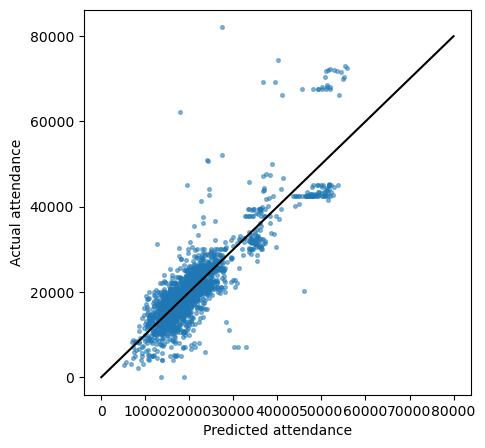

In [15]:
evaluate_linear_model(linreg, X, y)

There was no improvement to the fit and no indication that any of the weather parameters had an effect on the attendance. Weather parameters will not be included in the fit for subsequent models.

**Model 6**

For this model, I am going to remove parameters that were not significant. This means I will remove the following:

1. All weather parameters.
2. Kick off time parameters.

In [16]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','date_year',
                      'playoff','home_opener','rivals','real_home_team'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     85.76
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:49:26   Log-Likelihood:                -22059.
No. Observations:                2229   AIC:                         4.426e+04
Df Residuals:                    2157   BIC:                         4.467e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       585.3170     54.818     10.678      0.000     477.816     692.818
playoff         1234.8856    726.559      1.700      0.089    -189.944    2659.715
home_opener     2245.9457    501.684      4.477      0.000    1262.111    3229.781
rivals          2228.4335    401.071      5.556      0.000    1441.908    3014.959
real_home_team  7246.4885   1269.919      5.706      0.000    4756.096    9736.881
const           4.472e+04   1507.731     29.661      0.000    4.18e+04    4.77e+04
home_team_1    -2.834e+04    867.581    -32.661      0.000      -3e+04   -2.66e+04
home_team_2    -1.414e+04    995.497    -14.202      0.000   -1.61e+04   -1.22e+04
home_team_3     -3.49e+04    742.341    -47.013      0.000   -3.64e+04   -3.34e+04
home_team_4    -2.529e+04    791.608    -31.949      0.000   -2.68e+04   -2.37e+04
home_team_5    -3.557e+04    760.867    -46.748      0.000   -3.71e+04   -3.41e+04
home_team_6    -3.313e+04    740.888    -44.720      0.000   -3.46e+04   -3.17e+04
home_team_7    -3.421e+04    750.723    -45.566      0.000   -3.57e+04   -3.27e+04
home_team_8    -3.341e+04    739.082    -45.201      0.000   -3.49e+04    -3.2e+04
home_team_9    -3.451e+04    755.813    -45.666      0.000    -3.6e+04    -3.3e+04
home_team_10    -2.76e+04    754.017    -36.597      0.000   -2.91e+04   -2.61e+04
home_team_11   -2.787e+04    743.997    -37.456      0.000   -2.93e+04   -2.64e+04
home_team_12   -3.004e+04    749.272    -40.098      0.000   -3.15e+04   -2.86e+04
home_team_13   -3.377e+04    870.886    -38.780      0.000   -3.55e+04   -3.21e+04
home_team_14   -3.379e+04    781.827    -43.215      0.000   -3.53e+04   -3.23e+04
home_team_15   -2.345e+04    858.346    -27.314      0.000   -2.51e+04   -2.18e+04
home_team_16   -2.987e+04    748.587    -39.908      0.000   -3.13e+04   -2.84e+04
home_team_17   -3.027e+04    754.456    -40.121      0.000   -3.17e+04   -2.88e+04
home_team_18   -3.273e+04    745.428    -43.902      0.000   -3.42e+04   -3.13e+04
home_team_19   -2.974e+04    743.239    -40.020      0.000   -3.12e+04   -2.83e+04
home_team_20   -3.266e+04    727.529    -44.892      0.000   -3.41e+04   -3.12e+04
home_team_21   -2.737e+04    753.582    -36.322      0.000   -2.88e+04   -2.59e+04
home_team_22   -3.158e+04    750.741    -42.059      0.000    -3.3e+04   -3.01e+04
home_team_23   -3.306e+04    765.012    -43.211      0.000   -3.46e+04   -3.16e+04
home_team_24   -1.526e+04    746.269    -20.450      0.000   -1.67e+04   -1.38e+04
home_team_25   -3.085e+04    749.296    -41.177      0.000   -3.23e+04   -2.94e+04
home_team_26   -2.863e+04   1318.979    -21.708      0.000   -3.12e+04    -2.6e+04
home_team_27   -2.709e+04    751.436    -36.056      0.000   -2.86e+04   -2.56e+04
home_team_28   -3.243e+04    772.756    -41.961      0.000   -3.39e+04   -3.09e+04
away_team_1 

RMSE of residuals: 4884.843861590792
R-squared: 0.7384176459978459


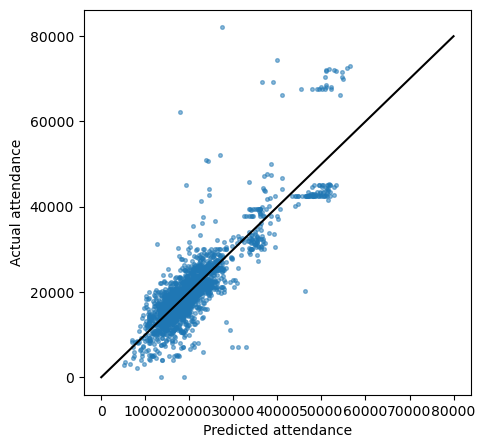

In [17]:
evaluate_linear_model(linreg, X, y)

This model has an R-squared of 0.738 and the RMSE is 4,885.

This is the best performing linear model. Below, I dig into the results a little more to see how well the model performed.

First, I am going to be using a train-test split for the other types of models I will try. In order to make a more direct comparison to those models, I would like to evaluate the linear regression model on those splits.

In [18]:
# Set random seed that will be used for ALL train-test splits
rando = 23

In [19]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rando, test_size=0.2)

RMSE:
Train: 4752.0
Test: 5012.6

R-squared:
Train: 0.74
Test: 0.733


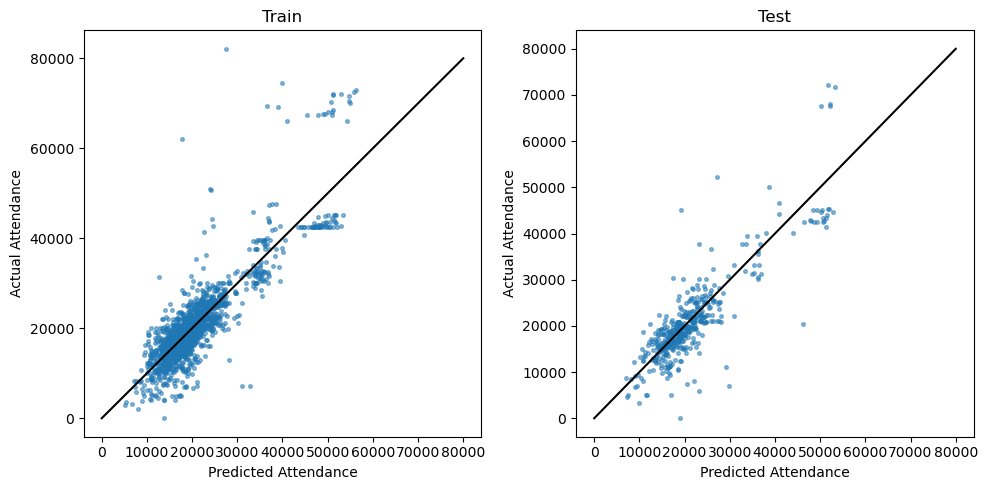

In [20]:
evaluate_model_split(linreg, X_train, y_train, X_test, y_test)

Despite fitting all of the data without the split, there does not appear to be an issue with overfitting. This is not surprising as a linear regression model is likely too simple to overfit the data.

For the other types of models, the benchmark performance for the test data is the following:

RMSE = 5,012.6

R-squared = 0.733

I want to look at how the fit performed on a team-by-team basis. The dictionary below turns the IDs in home_team and away_team into the actual team names.

In [21]:
team_names = {0: 'Atlanta United',
              1: 'Austin FC',
              2: 'Charlotte FC',
              3: 'Chicago Fire',
              4: 'FC Cincinnati',
              5: 'Colorado Rapids',
              6: 'Columbus Crew',
              7: 'FC Dallas',
              8: 'D.C. United',
              9: 'Houston Dynamo',
              10: 'Los Angeles Galaxy',
              11: 'Los Angeles FC',
              12: 'Minnesota United',
              13: 'Inter Miami',
              14: 'CF Montreal',
              15: 'Nashville SC',
              16: 'New England Revolution',
              17: 'New York City FC',
              18: 'New York Red Bulls',
              19: 'Orlando City',
              20: 'Philadelphia Union',
              21: 'Portland Timbers',
              22: 'Real Salt Lake',
              23: 'San Jose Earthquakes',
              24: 'Seattle Sounders',
              25: 'Sporting Kansas City',
              26: 'St. Louis FC',
              27: 'Toronto FC',
              28: 'Vancouver Whitecaps'}

In [22]:
# Get predictions from the model
y_pred_lr = linreg.predict(X)

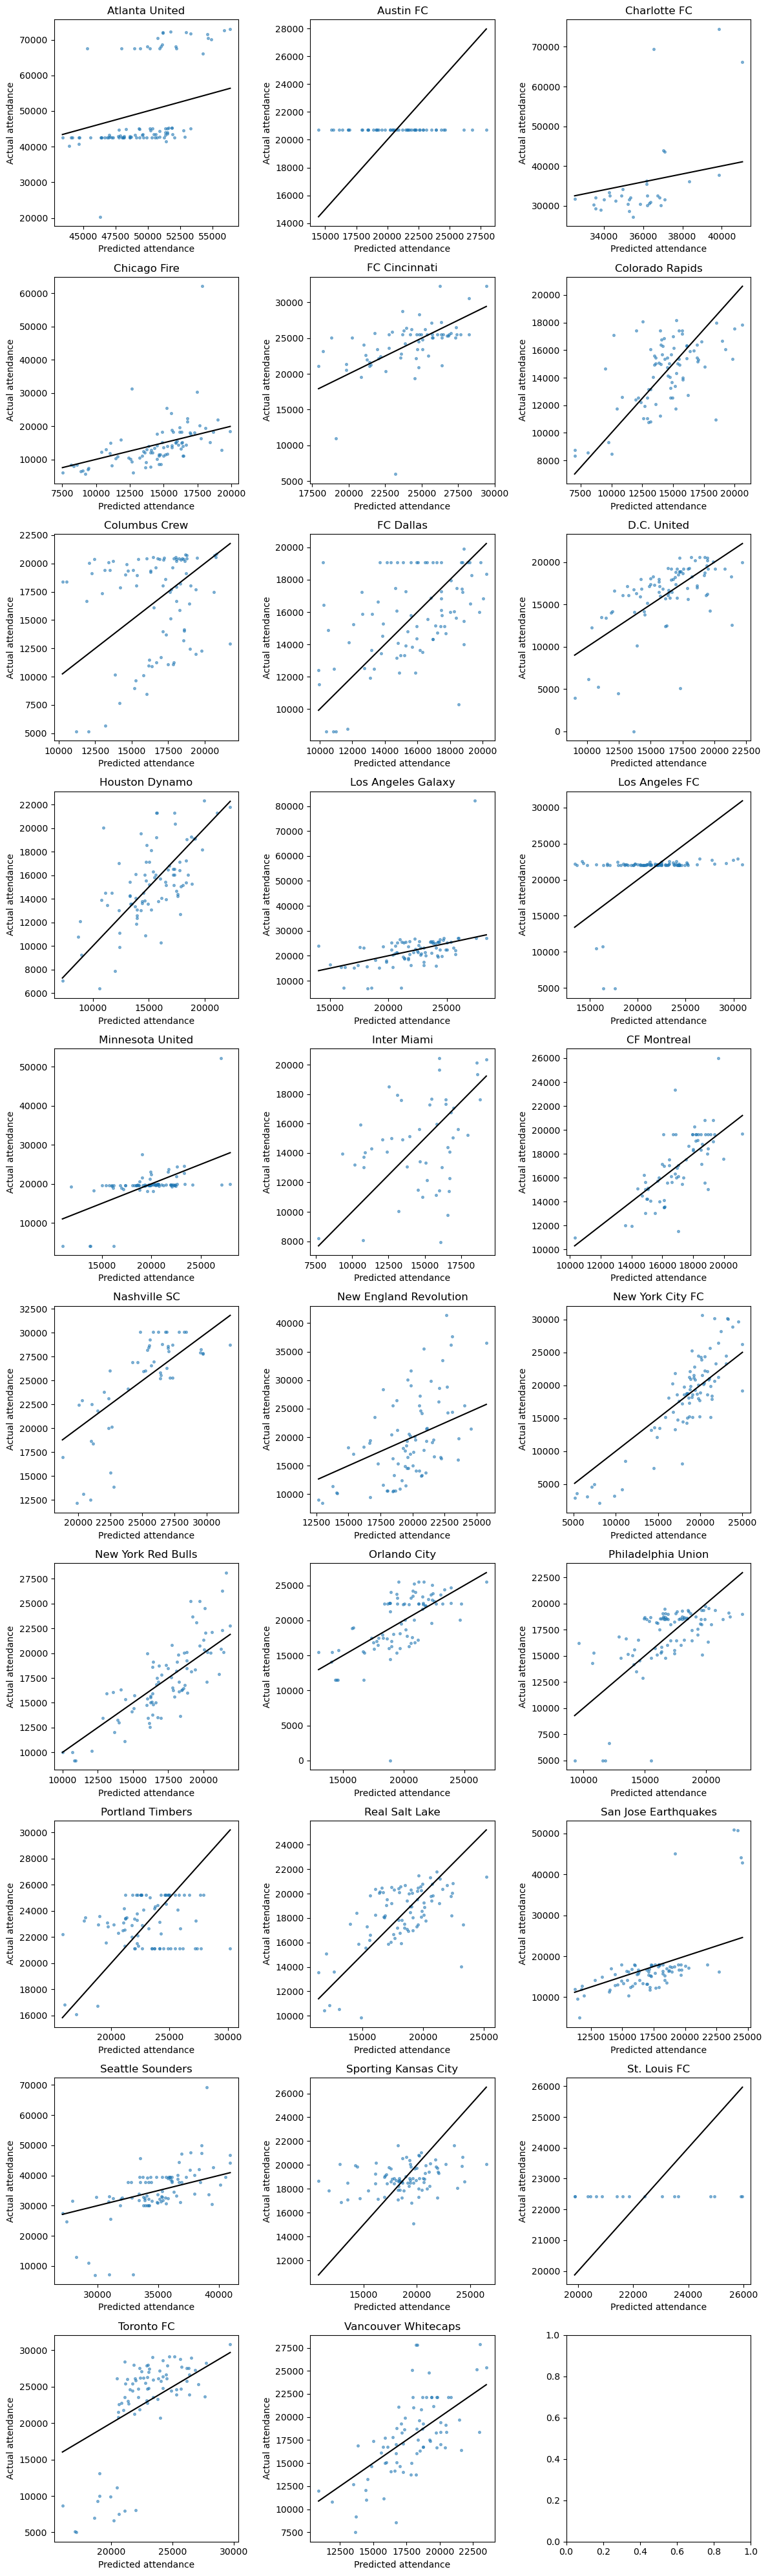

In [23]:
# Plot actual attendance vs. predicted attendance for each team's home matches
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,40))

for ht in range(29):
    r = ht//3
    c = ht%3
    
    y_pred_ht = y_pred_lr[mlsall_df['home_team']==ht]
    
    ax[r,c].scatter(y_pred_ht,
                    y[mlsall_df['home_team']==ht],
                    s=7,
                    alpha=0.5)
    
    ax[r,c].set_title(team_names[ht])
    ax[r,c].set_xlabel('Predicted attendance')
    ax[r,c].set_ylabel('Actual attendance')
    
    ax[r,c].plot([np.min(y_pred_ht),np.max(y_pred_ht)],
                 [np.min(y_pred_ht),np.max(y_pred_ht)],
                 color='black')
    
fig.tight_layout()

The predictions are quite solid for some teams, but not for others.

The model struggles the most with teams that change the capacity of their stadiums. Atlanta United is a good example. Usually, they use a capacity around 45,000, but then expand it to over 70,000 for other matches. The changing capacity means that the model struggles to fit the data which is grouped into two parts of the graph. In the case of Atlanta, I can tell pretty clearly what capacity was being used in a given match, but that is not the case for all teams.

The artifically reduced capacity of Gillette Stadium, used by the New England Revolution, is listed as 20,000, but many of their matches have a higher attendance than that. In contrast to teams like Atlanta United, there seems to be a continuum of values above 20,000 rather than one unique, higher capacity. This implies that New England uses a less rigid capacity for its home matches, making it impossible to tell what capacity they used, if they used one at all.

The model also struggled with teams that had very consistent home attendance. The most obvious cases are Austin FC and St. Louis FC who have had the same (or nearly the same attendance) for every home match they have played. The model expects the attendance to vary from match to match depending on changes in the parameters, but there just isn't any variance for these teams. Similar issues are present for these teams that just have less variance in attendance: Los Angeles FC, Minnesota United, and Sporting Kansas City.

These teams outline a second problem with the model which is that there is a true maximum capacity for each stadium that cannot be exceeded, but the linear model does not incorporate that limit. Austin FC cannot have more than 20,738 people in Q2 Stadium, but the model still predicts values greater than that value.

One metric for judging how well the model fits each team is the RMSE. Below, I plot the RMSE for each teams' home matches.

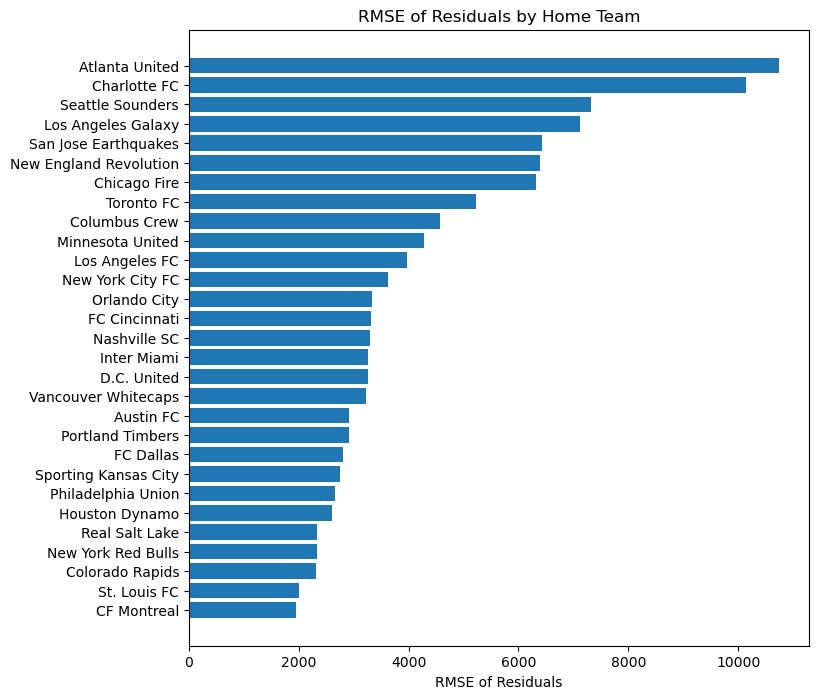

In [24]:
# RMSE of residuals for each home team
fig, ax = plt.subplots(figsize=(8,8))

rmse_team = []
for ht in range(29):
    rmse_team.append(np.sqrt(np.var(linreg.resid[mlsall_df['home_team']==ht])))
    
ax.barh(y=np.arange(29), width=np.sort(rmse_team))

ax.set_yticks(np.arange(29))
ax.set_yticklabels([team_names[x] for x in np.argsort(rmse_team)])
ax.set_xlabel('RMSE of Residuals')
ax.set_title('RMSE of Residuals by Home Team');

Unsurprisingly, the highest RMSE values are for the 3 teams that often change their stadium capacity (Atlanta, Charlotte, and Seattle). For 19 of the 29 teams, the RMSE is below 4,000.

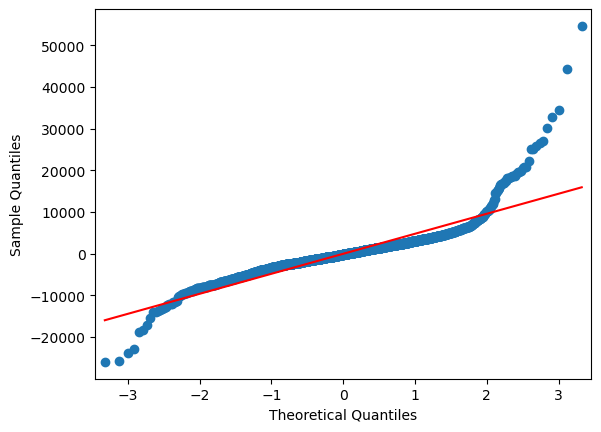

In [25]:
# Make Quantile-Quantile plot to compare to normal distribution
sm.qqplot(linreg.resid,line='s');

The Q-Q plot above shows that the distribution of residuals is close to normal except at the edges.

### XGBoost Regression

Next, I use an extreme gradient boosting regression model, XGBRegressor.

**Model 1**

First, I want to see how well XGBRegressor performs with the default hyperparameters.

I am going to include all of the possible columns in my input data.

In [26]:
# Create input DataFrame, X
X = create_X(mlsall_df, columns=['home_team','away_team',
                                 'day','date_month','date_year','local_time',
                                 'playoff','home_opener','rivals','real_home_team',
                                 'temperature','rain','snow','windspeed'],
             drop_first=False)
# Apply the same train-test split that was used earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rando, test_size=0.2)

RMSE:
Train: 971.3
Test: 4814.8

R-squared:
Train: 0.989
Test: 0.754


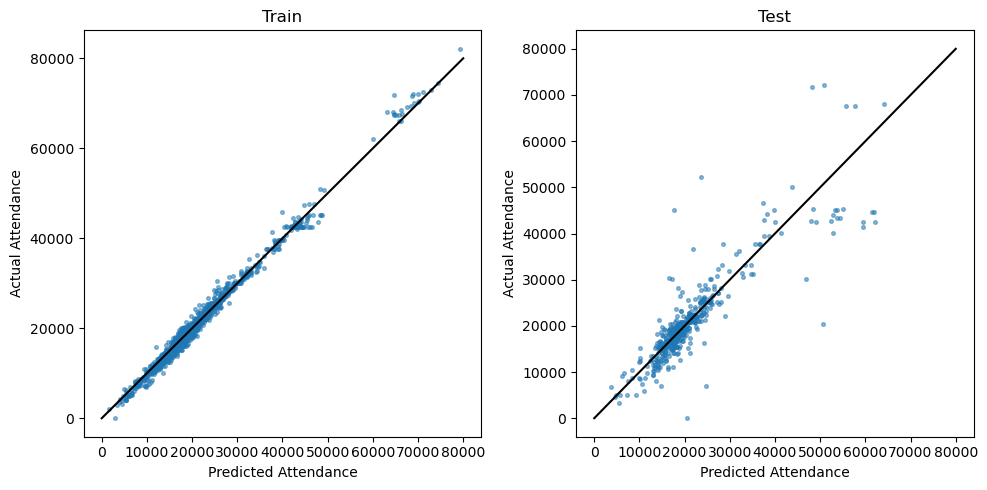

In [27]:
# Instantiate XGBClassifier
xgb = XGBRegressor()

# Fit model
xgb.fit(X_train, y_train)

# Evaluate XGBRegressor model
evaluate_model_split(xgb, X_train, y_train, X_test, y_test)

The model is overfitting quite a bit as the R-squared value is 0.989 for the train dataset, but just 0.754 for the test dataset. The RMSE is also higher for the test data. Some hyperparameters will need to be adjusted to improve the fit.

Both the RMSE and R-squared values are better for the test data than they were for the linear regression model. Below, I start adjusting hyperparameters to improve the model further.

**Model 2**

Below, I use a custom function, xgb_gridsearch, which can be found in model_funcs.py. First, I just want to try out different tree depths and number of estimators.

In [28]:
# Create parameter grid
param_grid_xgb = {
    'max_depth': [3,4,5,6,7,8,9,None],
    'n_estimators': [50,100,200,250,300,350,400],
    'booster': ['gbtree']
}

# Search for optimal parameter combination
xgb_best, best_params, params, scores = model_gridsearch('xgb',param_grid_xgb, X_train, y_train, X_test, y_test)

{'max_depth': 4, 'n_estimators': 100, 'booster': 'gbtree'}
RMSE:
Train: 2026.9
Test: 4467.4

R-squared:
Train: 0.953
Test: 0.788


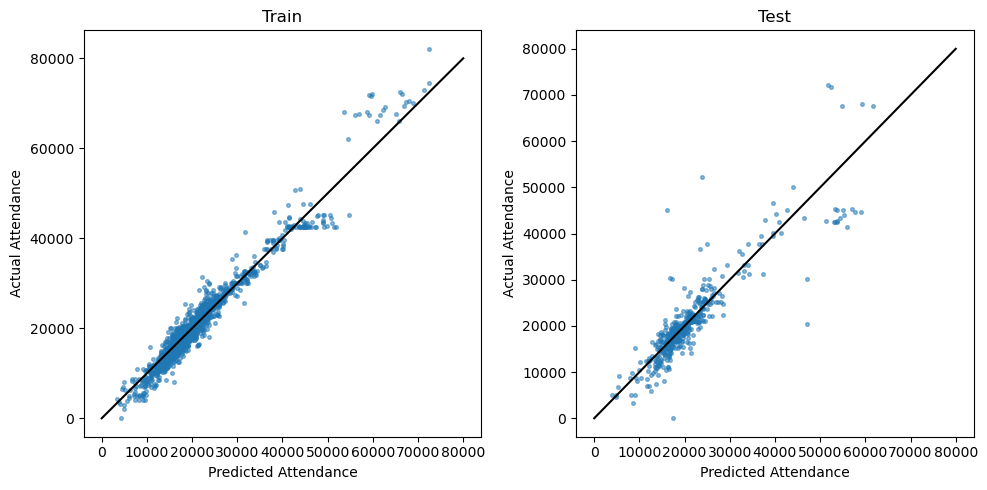

In [29]:
# Evaluate XGBRegressor model
print(best_params)
evaluate_model_split(xgb_best, X_train, y_train, X_test, y_test)

The best model had a max_depth of 4 and 100 estimators.

The performance improved a bit from the last model. The RMSE and R-squared are now 4,467.4 and 0.788, respectively.

The model did overfit as the metrics for the training data was significantly better than the test data. Some regularization might come in handy.

**Model 3**

Next, I introduce learning_rate, reg_lambda, and subsample to the parameter grid. The hope is that reg_lambda and subsample will help with the overfitting.

In [30]:
# Create parameter grid
param_grid_xgb = {
    'max_depth': [3,4,5,6],
    'n_estimators': [25,50,75,100,125,150,200,250,300],
    'booster': ['gbtree'],
    'learning_rate':[0.3,0.4,0.5,0.6],
    'reg_alpha':[0.01,0.1,1,10],
    'subsample':[0.7,0.8,0.9,1]
}

# Search for optimal parameter combination
xgb_best, best_params, params, scores = model_gridsearch('xgb',param_grid_xgb, X_train, y_train, X_test, y_test)

{'max_depth': 4, 'n_estimators': 25, 'booster': 'gbtree', 'learning_rate': 0.6, 'reg_alpha': 10, 'subsample': 0.9}
RMSE:
Train: 2685.7
Test: 4408.7

R-squared:
Train: 0.917
Test: 0.793


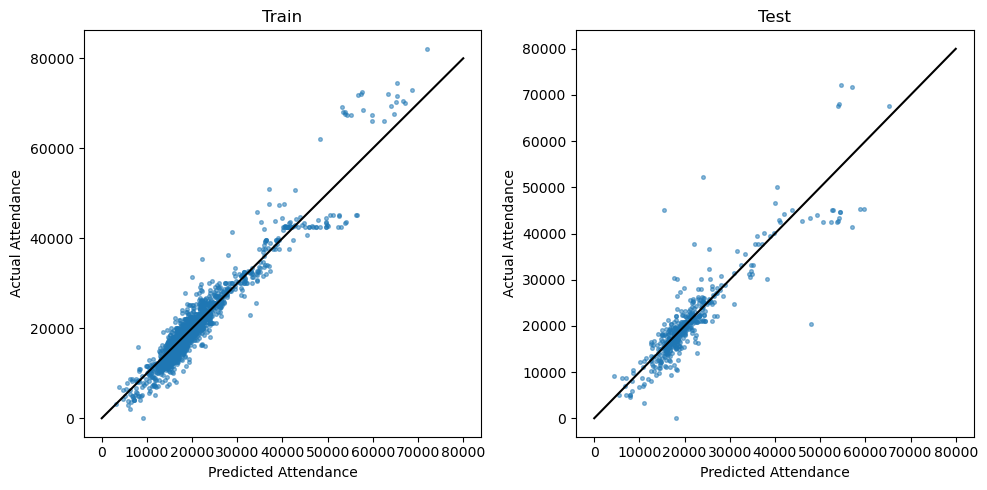

In [31]:
# Evaluate XGBRegressor model
print(best_params)
evaluate_model_split(xgb_best, X_train, y_train, X_test, y_test)

The fit once again improved a bit. The new RMSE and R-squared values are 4,408.7 and 0.793.

The best parameter values were:

1. max_depth = 4
2. n_estimators = 25
3. learning_rate = 0.6
4. reg_alpha = 10
5. subsample = 0.9

The overfitting is still present.

**Number of estimators**

Below, I want to check to see how the performance changes as the number of estimators increases. All other hyperparameters will take on the values they had in the best model so far.

In [32]:
# Create parameter grid
param_grid_xgb = {
    'max_depth': [4],
    'n_estimators': [10,15,20,25,30,35,40,45,50,75,100,125,150,200,250,300,350,400,450,500],
    'booster': ['gbtree'],
    'learning_rate':[0.6],
    'reg_alpha':[10],
    'subsample':[0.9]
}

# Search for optimal parameter combination
xgb_best, best_params, params, scores = model_gridsearch('xgb',param_grid_xgb, X_train, y_train, X_test, y_test)

In [33]:
best_params

{'max_depth': 4,
 'n_estimators': 25,
 'booster': 'gbtree',
 'learning_rate': 0.6,
 'reg_alpha': 10,
 'subsample': 0.9}

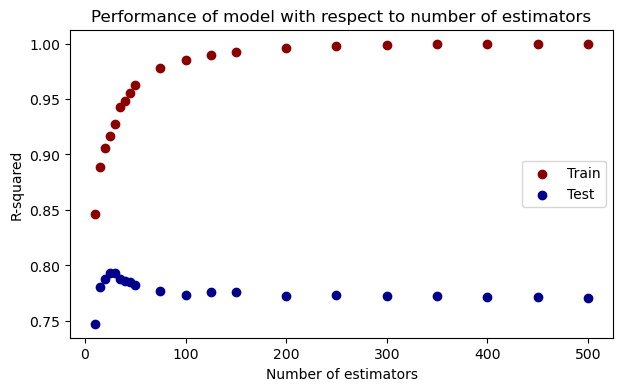

In [34]:
# plot R-squared values vs. number of estimators
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(param_grid_xgb['n_estimators'],scores[:,0],label='Train', color='darkred')
ax.scatter(param_grid_xgb['n_estimators'],scores[:,1],label='Test',color='darkblue')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('R-squared')
ax.set_title('Performance of model with respect to number of estimators')

ax.legend()

The R-squared value for the test data maxes out at 0.793 when the number of estimators is 25. After that, the R-squared value begins to drop a bit.

Summary for XGBRegressor: The XGB model was able to outperform the linear regression model. The best R-squared value was just below 0.8 and the best RMSE was 4,408.7. Next, I will try random forest regression to see if it can outperform these metrics.

### Random Forest Regression

The random forest regressor will use the same training and test data as the XGB regressor.

**Model 1**

First, I will try the default hyperparameters for RandomForestRegressor.

RMSE:
Train: 1622.3
Test: 5137.9

R-squared:
Train: 0.97
Test: 0.72


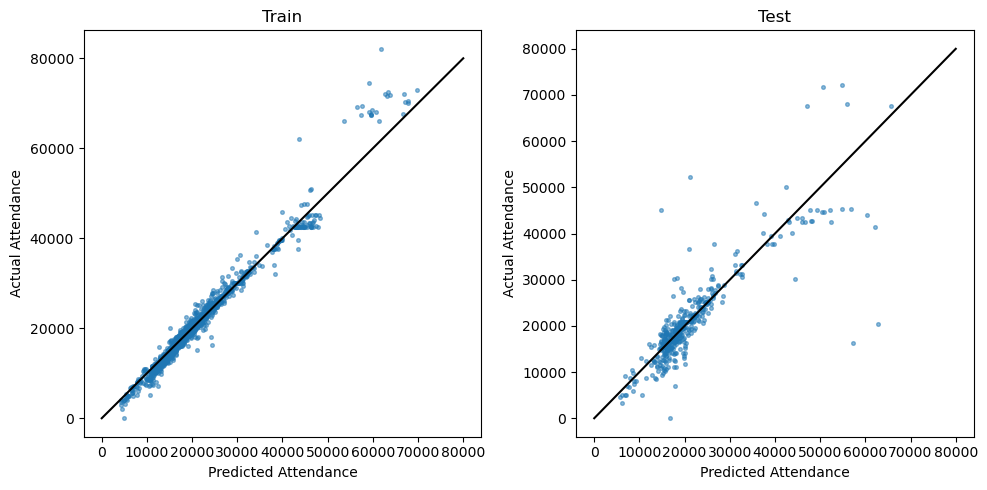

In [35]:
# Create instance of RandomForestRegressor
rfr = RandomForestRegressor()

# Fit the model
rfr.fit(X_train, y_train)

# Evaluate the fit
evaluate_model_split(rfr, X_train, y_train, X_test, y_test)

The R-squared for this model is 0.725 and the RMSE is 5,084.0. Like the default XGBRegressor model, this is significantly overfitting.

**Model 2**

Next, I do a grid search on the following parameters:

1. Number of estimators
2. Max depth
3. Minimum samples to split a node

In [36]:
# Create parameter grid
param_grid_rfr = {
    'n_estimators': [5,10,15,20,25,30,40,50],
    'max_depth': [20,30,40,50,60,70,80],
    'min_samples_split': [2,3,4,5,6,7]
}

# Search for optimal parameter combination
rfr_best, best_params, params, scores = model_gridsearch('rfr', param_grid_rfr, X_train, y_train, X_test, y_test)

{'n_estimators': 15, 'max_depth': 40, 'min_samples_split': 3}
RMSE:
Train: 2100.5
Test: 4802.9

R-squared:
Train: 0.949
Test: 0.755


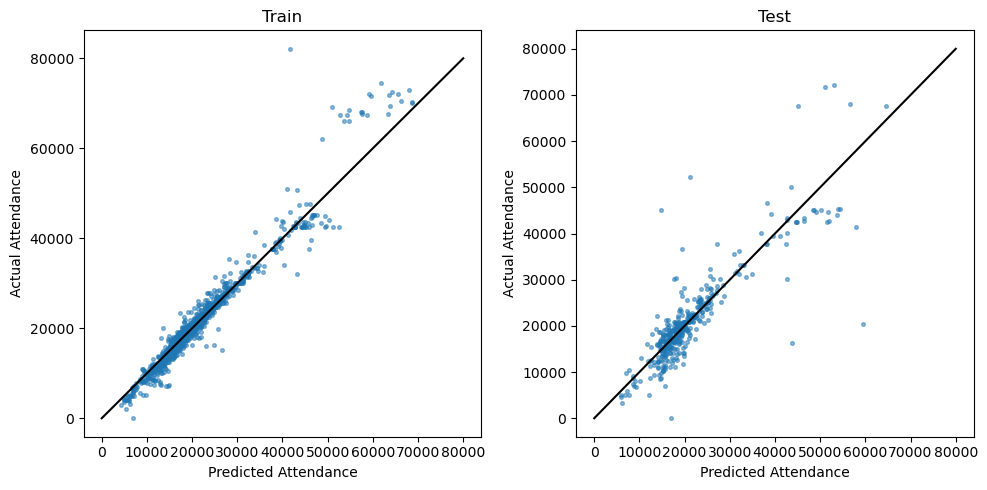

In [37]:
print(best_params)
evaluate_model_split(rfr_best, X_train, y_train, X_test, y_test)

The fit on the test data did improve a bit. The RMSE is 4,650.8 and the R-squared is 0.77. The model is still overfitting quite a bit.

The performance of this model is worse than the best XGB model. This is not surprising since XGB also uses decision trees, but uses a more sophisticated algorithm to improve the fit each iteration.

### K Nearest Neighbors

The last type of model I will try is a K-Nearest Neighbors model. Specifically, I will use KNeighborsRegressor.

In theory, I think this type of model could be quite effective if there was enough data. However, I expect that this model will struggle to match the performance of the other models because certain features have less data coverage.

**Model 1**

I start with the default hyperparameters for KNeighborsRegressor.

RMSE:
Train: 7040.4
Test: 8853.3

R-squared:
Train: 0.429
Test: 0.167


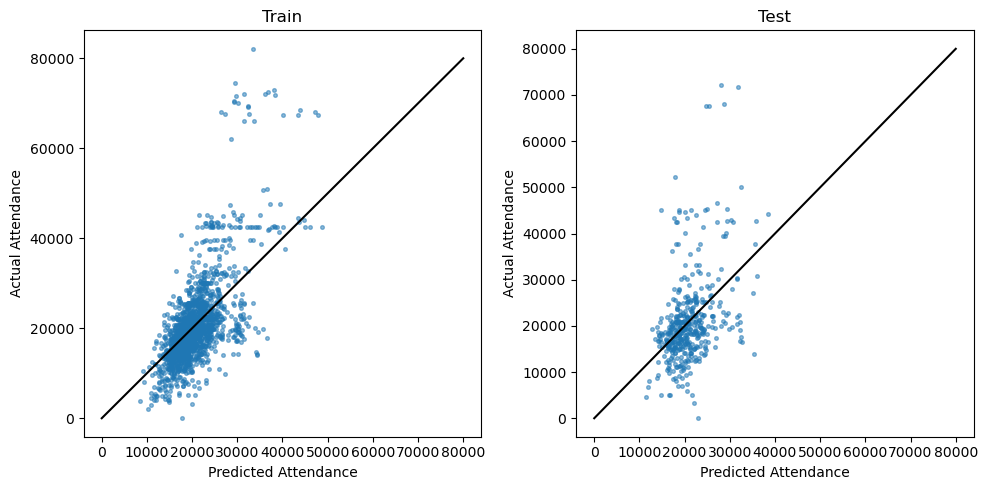

In [38]:
# Create instance of KNeighborsRegressor
knn = KNeighborsRegressor()

# Fit the model
knn.fit(X_train, y_train)

# Evaluate the fit
evaluate_model_split(knn, X_train, y_train, X_test, y_test)

The model performed very poorly on both the training and test data. The hyperparameters need some tuning to improve the model.

Both the XGBRegressor and RandomForestRegressor performed quite well without tuning anything. This might confirm what I said above about this model struggling.

**Model 2**

Next, I adjust values for the following parameters:

1. Number of neighbors
2. Minkowski metric exponent, p.
3. Whether to weight with distance or not.

In [39]:
# Create parameter grid
param_grid_knn = {
    'n_neighbors': [5,10,15,20,25,30,40,50],
    'p': [1,1.5,2,2.5,3],
    'weights': ['uniform','distance']
}

# Search for optimal parameter combination
knn_best, best_params, params, scores = model_gridsearch('knn', param_grid_knn, X_train, y_train, X_test, y_test)

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
RMSE:
Train: 0.0
Test: 8131.9

R-squared:
Train: 1.0
Test: 0.297


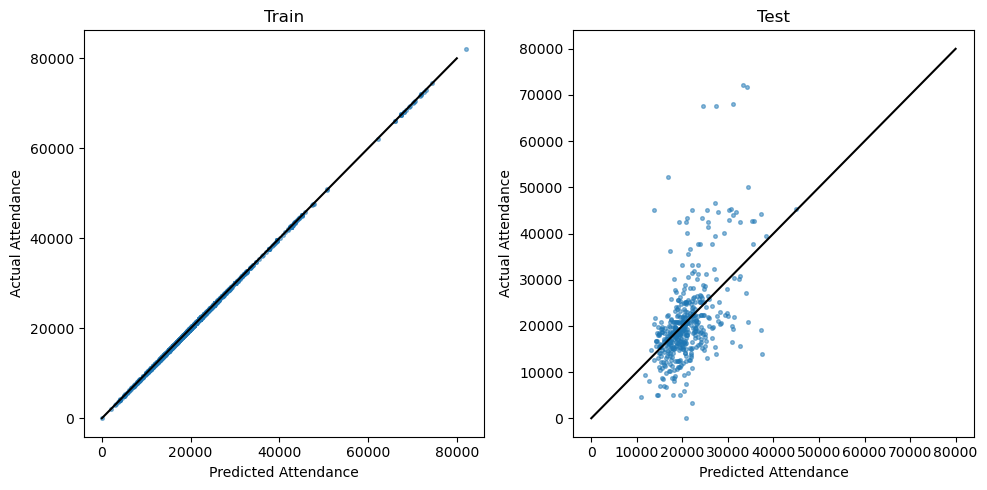

In [40]:
# Evaluate the fit
print(best_params)
evaluate_model_split(knn_best, X_train, y_train, X_test, y_test)

The model suffers from severe overfitting and the performance on the test data is still very bad (RMSE=8,131.9 and R-squared=0.297). Since I already have other types of models that perform well, I am going to stop here for K-Nearest Neighbors.

### Summary of Models

The best performing instance of each model is summarized in the table below.

| Model               | RMSE (Test) | $R^2$ (Test) | RMSE (Training) | $R^2$ (Training) |
|---------------------|-------------|--------------|-----------------|------------------|
| XGBoost             | 4,408.7     | 0.793        | 2,685.7         | 0.917            |
| Random Forest       | 4,650.8     | 0.770        | 2,289.8         | 0.940            |
| Linear Regression   | 5,012.6     | 0.733        | 4,752.0         | 0.740            |
| K-Nearest Neighbors | 8,131.9     | 0.207        | 0.0             | 0.000            |

The RMSE and $R^2$ values are for the test dataset which comprises 20% of the data. For each model except linear regression, the model was trained on the other 80% of the data. The train-test split was not used for linear regression because there was no concern that the model would overfit.

**Overall performance**

The first three types of models (linear regression, XGBoost, and Random Forest) each achieved RMSE values around or below 5,000 and R-squared values between 0.73 and 0.8. However, the K-Nearest Neighbors model struggled to match this level of performance. There might have been some room for improvement by tweaking the scaling of the input variables, but I doubt the predictions would have been as good as the other three.

As stated at the top of this notebook, the match-by-match predictions are not stellar. The best RMSE was around 4,400. This means that we expect a typical prediction to be off by about this much on average. This is not a problem, though. The goal of this project was to look for trends that MLS could use to improve attendance over the course of a season, not to target specific matches to try to improve attendance. There are trends that can be useful which will be discussed in the **Exploring the Model** section of this notebook.

**The Best Performing Model**

The model that performed the best based on having the lowest RMSE and highest R-squared was the XGBoost Regression model. The model did suffer from some overfitting, but efforts to decrease the overfitting, such as increasing the regularization or decreasing the number of iterations, only reduced the performance on the test data.

### Exploring the Model

In this section, I primarily explore the best-fitting XGBoost model, but I am also going to mention the linear regression model sometimes for comparison.

**Residuals**

First, I want to look into the residuals. I already know that the RMSE is around 4,400 for the best model, but I want to look at how it is distributed.

In [41]:
# I will use the blue and red from the MLS logo in some figures
mls_blue = '#001F5B'
mls_red = '#DF231A'

Kurtosis of Residuals: 13.481246785624222
Proportion of predictions within 1000 of actual value: 0.3452914798206278
Proportion of predictions within 2000 of actual value: 0.600896860986547
Proportion of predictions within 3000 of actual value: 0.7399103139013453
Proportion of predictions within 4000 of actual value: 0.8363228699551569


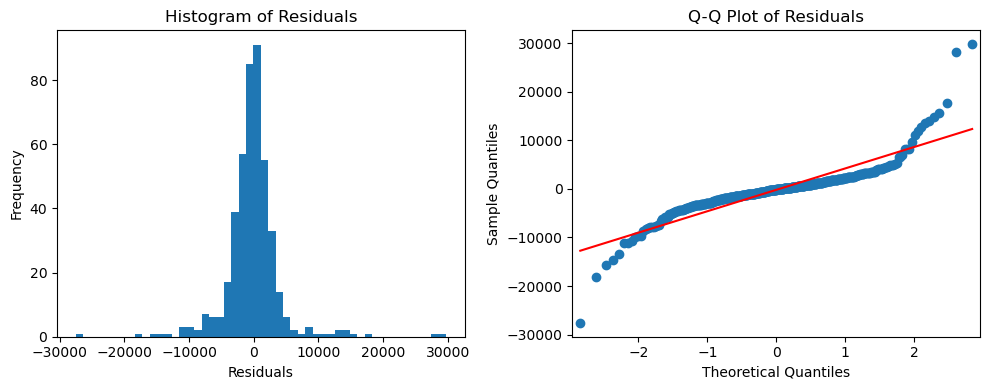

In [42]:
# Calculate residuals of test data
xgb_resid = y_test-xgb_best.predict(X_test)

# Kurtosis
print(f"Kurtosis of Residuals: {sp.kurtosis(xgb_resid)}")
print(f"Proportion of predictions within 1000 of actual value: {np.sum(np.abs(xgb_resid)<1000)/len(xgb_resid)}")
print(f"Proportion of predictions within 2000 of actual value: {np.sum(np.abs(xgb_resid)<2000)/len(xgb_resid)}")
print(f"Proportion of predictions within 3000 of actual value: {np.sum(np.abs(xgb_resid)<3000)/len(xgb_resid)}")
print(f"Proportion of predictions within 4000 of actual value: {np.sum(np.abs(xgb_resid)<4000)/len(xgb_resid)}")

# Plot residuals and a Q-Q plot
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

# Residual distribution
ax[0].hist(xgb_resid, bins=50)
ax[0].set_xlabel('Residuals')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Residuals')

# Q-Q plot
sm.qqplot(xgb_resid,line='s',ax=ax[1])
ax[1].set_title('Q-Q Plot of Residuals')

fig.tight_layout();

The distribution of the residuals appears pretty symmetric, but more centrally concentrated than a normal distribution. This is verified by the kurtosis value of 13.5. A normal distribution would have a kurtosis of 0, while positive values imply more central concentration.

The Q-Q plot on the right shows how there are some large outliers on the edges. This is seen in the histogram as there are some residuals that are above 10,000, even as high as almost 30,000. However, the vast majority of the residuals are smaller than that. Even though the RMSE is 4,400, 60% of the predictions are within 2,000 of the correct value and 74% are within 3,000.

**Performance by Team**

Below, I plot the actual attendance vs. the predicted attendance for each team's home matches. The goal is to see whether the model performed consistently well for each team, or if it was better for some teams compared to others.

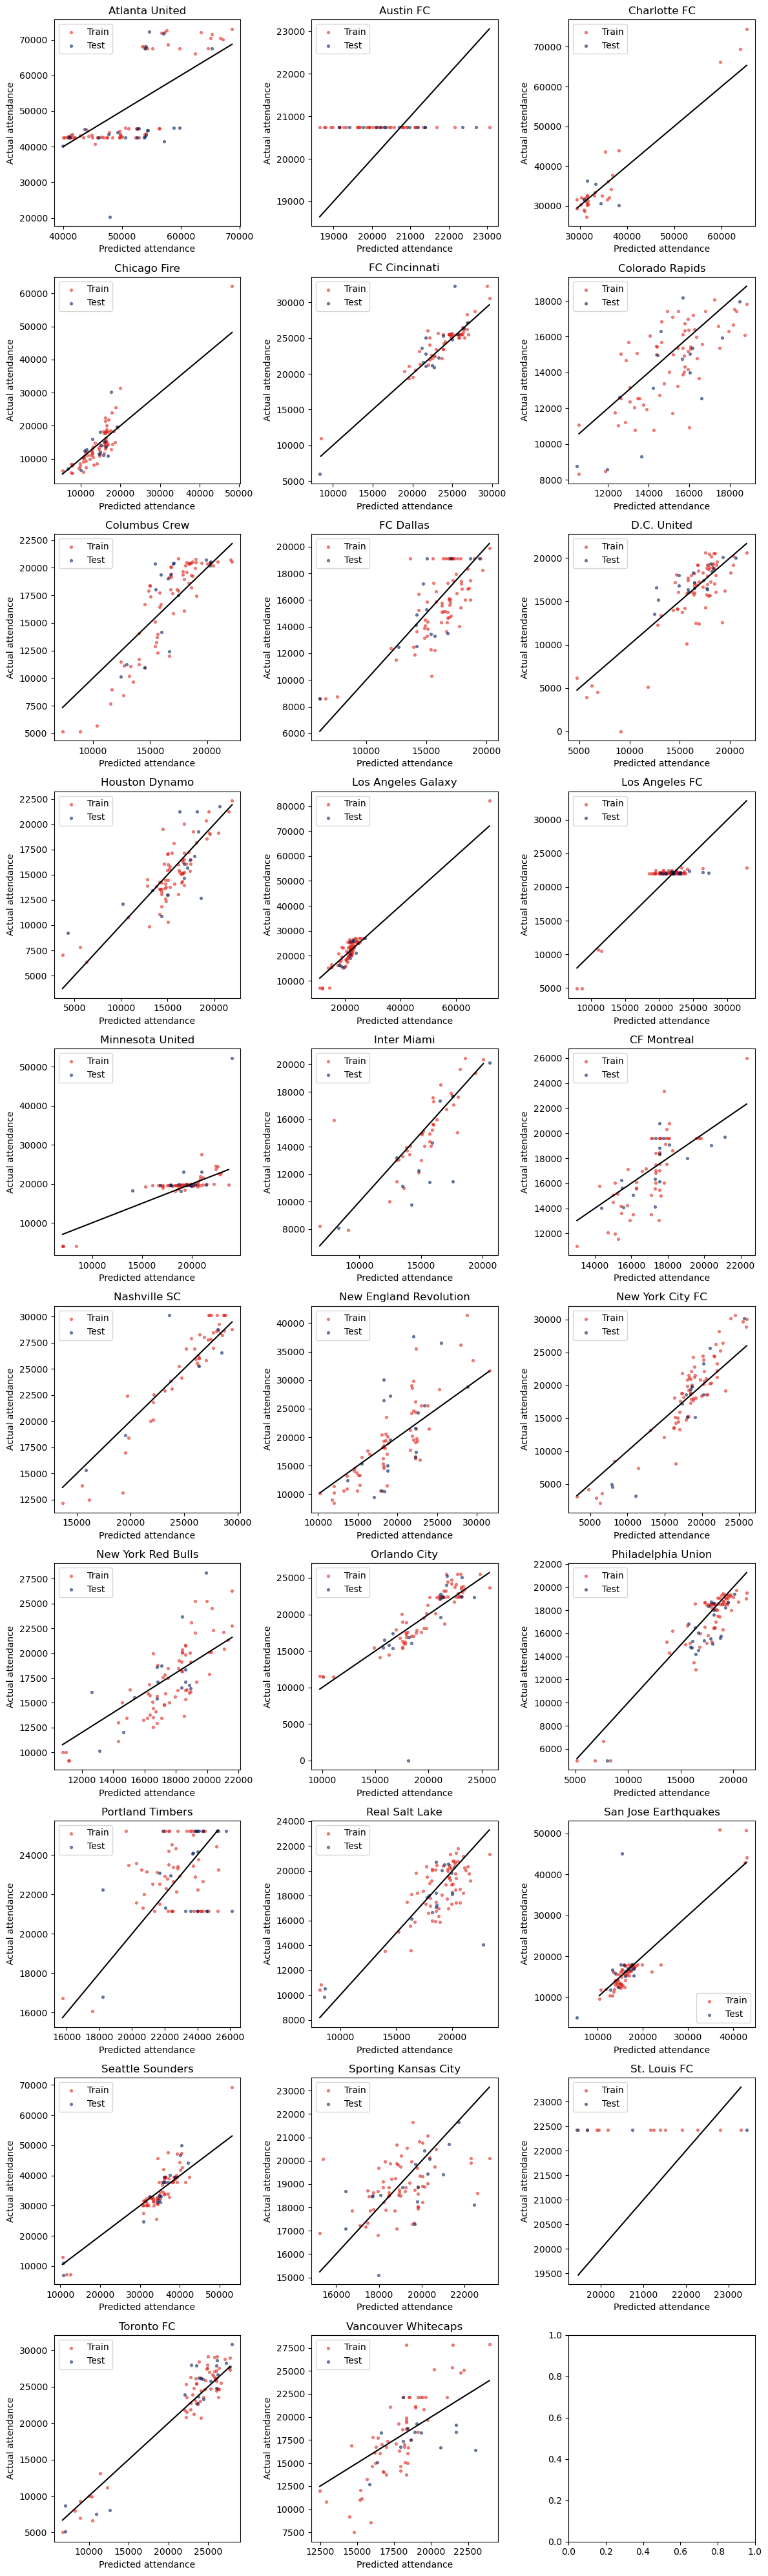

In [43]:
# Get predictions from the best XGB model
y_pred_train_xgb = xgb_best.predict(X_train)
y_pred_test_xgb = xgb_best.predict(X_test)

# Plot actual attendance vs. predicted attendance for each team's home matches
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,40))

for ht in range(29):
    r = ht//3
    c = ht%3
    
    train_select = X_train[f"home_team_{ht}"]==1
    test_select = X_test[f"home_team_{ht}"]==1
    
    # Training data
    ax[r,c].scatter(y_pred_train_xgb[train_select],
                    y_train[train_select],
                    s=8,
                    alpha=0.5,
                    label='Train',
                    color=mls_red)
    
    # Test data
    ax[r,c].scatter(y_pred_test_xgb[test_select],
                    y_test[test_select],
                    s=8,
                    alpha=0.5,
                    label='Test',
                    color=mls_blue)
    
    ax[r,c].set_title(team_names[ht])
    ax[r,c].set_xlabel('Predicted attendance')
    ax[r,c].set_ylabel('Actual attendance')
    
    # Plot x=y line
    ax[r,c].plot([np.min(y_pred_train_xgb[train_select]),np.max(y_pred_train_xgb[train_select])],
                 [np.min(y_pred_train_xgb[train_select]),np.max(y_pred_train_xgb[train_select])],
                 color='black')
    
    ax[r,c].legend()
    
fig.tight_layout();

The first thing I notice is that the model struggled with the teams who change the capacity of their stadiums, like Atlanta United (first plot in top left). Even on the training data, it tends to overestimate the attendance when the lower capacity is used and underestimate it when the larger capacity is used.

It can be a little hard to tell how good the different fits are because not all of the plots are on the same scale.

Below, I look at the RMSE of the residuals for each team's home matches. Only the matches in the test dataset are used.

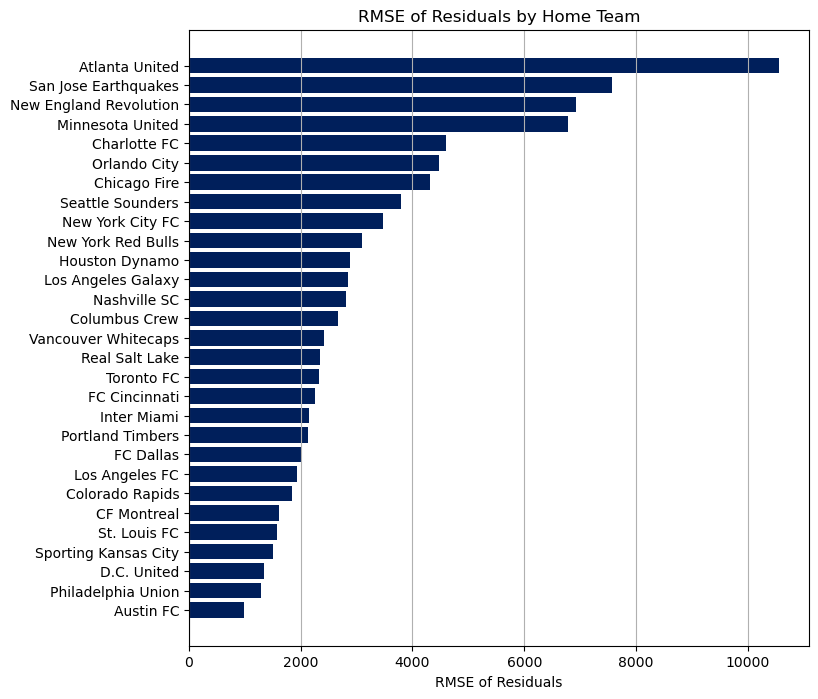

In [44]:
# RMSE of residuals for each home team
fig, ax = plt.subplots(figsize=(8,8))

rmse_team = []
for ht in range(29):
    rmse_team.append(np.sqrt(np.var(xgb_resid[mlsall_df['home_team']==ht])))
    
ax.barh(y=np.arange(29), width=np.sort(rmse_team), color=mls_blue)
ax.grid(axis='x')

ax.set_yticks(np.arange(29))
ax.set_yticklabels([team_names[x] for x in np.argsort(rmse_team)])
ax.set_xlabel('RMSE of Residuals')
ax.set_title('RMSE of Residuals by Home Team');

Not surprisingly, the highest RMSE was for Atlanta United whose trouble fitting I discussed earlier.

The second highest RMSE belongs to San Jose, but I think that is primarily caused by a single match that had a much higher attendance than predicted because the match was staged in a special location with much higher capacity.

The third highest RMSE belongs to New England. This also changes its capacity from match to match. The only other team with an RMSE above 5,000 was Minnesota United that also had a match with a higher than normal capacity.

Other than the 4 teams with the highest RMSE values, all the others have RMSE values below 5,000 and most are at 3,000 or below.

**Feature Importance**

The main goal of this project was to figure out what factors had the greatest effect on attendance. I start by looking at the feature importance calculated by XGBoost below.

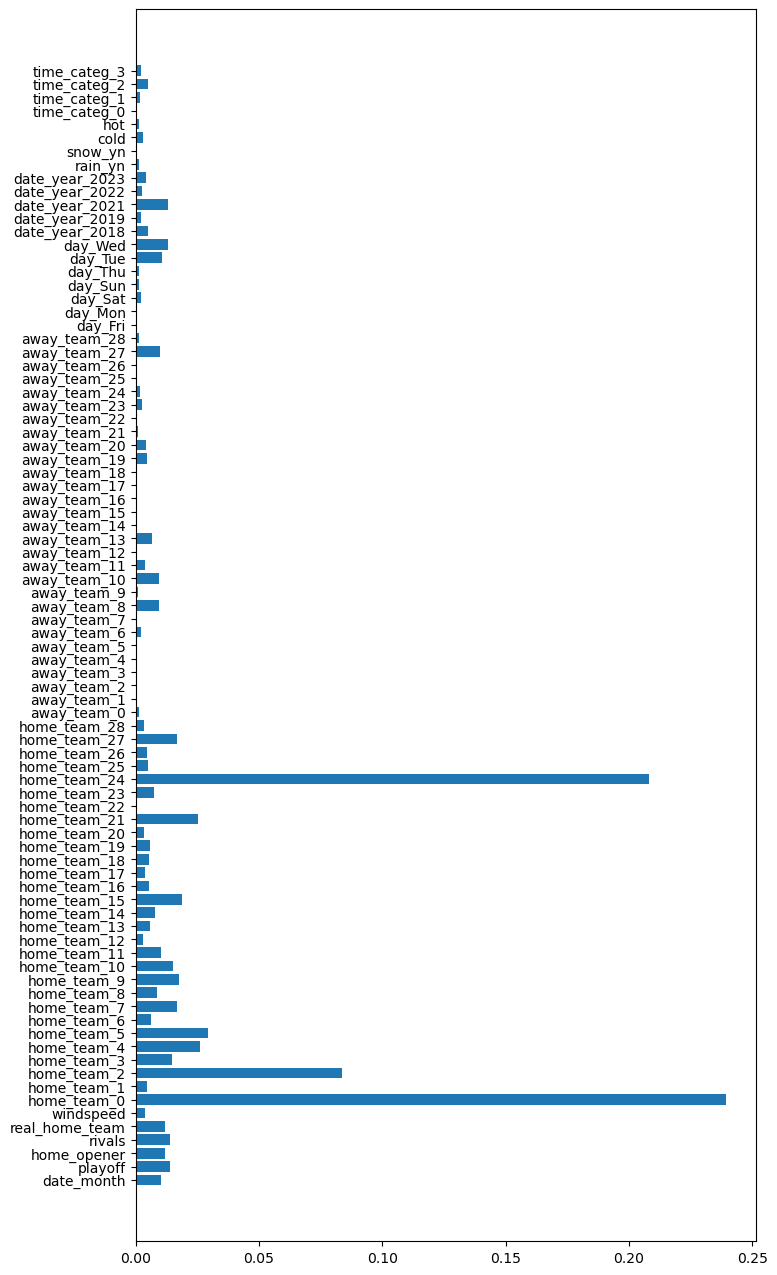

In [45]:
# Feature importance bar chart
fig, ax = plt.subplots(figsize=(8,16))
    
ax.barh(y=range(len(xgb_best.feature_importances_)), width=xgb_best.feature_importances_)

ax.set_yticks(range(len(xgb_best.feature_importances_)))
ax.set_yticklabels(xgb_best.feature_names_in_);

The most important features are those related to which team is at home. Part of the reason for this is simply that some teams have larger stadiums. The largest value in the plot above belongs to home_team_0, which is Atlanta United who play their matches in a big NFL stadium.

The trouble with the built-in feature_importances that are provided by the model is that they are normalized to add to 1 and it is hard to tell what actual effect each feature has on the attendance, especially because it does not indicate whether it has a positive or negative effect. I wrote my own function, get_feature_importance, that will attempt to measure the effect of each feature in more practical terms. The way I do this is by using the model on fake data, changing the input to see how the average attendance changes.

The fake data is generated below using the gen_fake_data function. The data contains each possible matchup between the 29 teams in MLS so that everyone plays everyone else once at home and once away (812 matches). The matches all assume the same default values for the other inputs at first. Those defaults are:

1. Match held on a Saturday in July, 2018 at 7:30 pm.
2. Not a playoff match, home opener, or rivalry match.
3. No rain or snow and the temperature is not considered hot or cold.
4. The real home team is present.

For each feature, I change the feature to compare it to the predicted attendance given the default values. For example, if I want to know the effect of playing matches on Wednesday instead of Saturday, I change all the matches to Wednesday and get the average of the predictions so it can be compared to the default average.

In [46]:
# Generate fake data
X_fake = gen_fake_data(X_train)
X_fake

,date_month,playoff,home_opener,rivals,real_home_team,windspeed,home_team_0,home_team_1,home_team_2,home_team_3,...,date_year_2022,date_year_2023,rain_yn,snow_yn,cold,hot,time_categ_0,time_categ_1,time_categ_2,time_categ_3
1,0,0,0,0,1,11,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,11,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,11,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
836,0,0,0,0,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
837,0,0,0,0,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
838,0,0,0,0,1,11,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
# Get feature importance for the best XGB model
xgb_importance, xgb_import_ht = get_feature_importance(xgb_best, X_fake, split_home_team=True)

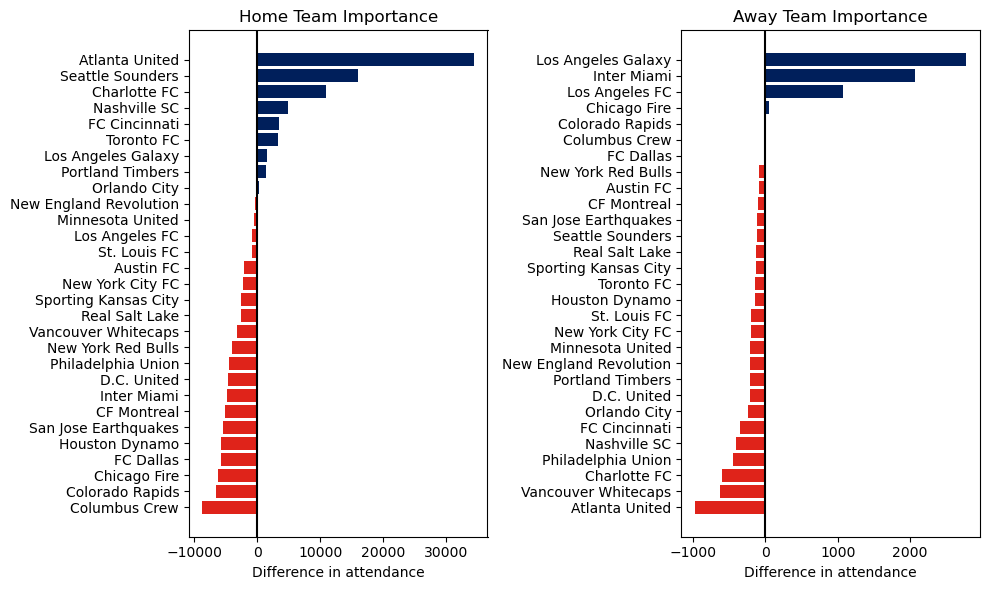

In [48]:
# Home team and away team feature importance
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

ht_importance = [xgb_importance[key] for key in xgb_importance.keys() if 'home_team_' in key]
ax[0].barh(y=range(29),
           width=np.sort(ht_importance),
           color=[mls_blue if x>=0 else mls_red for x in np.sort(ht_importance)])
ax[0].set_title('Home Team Importance')
ax[0].set_yticks(range(29))
ax[0].set_yticklabels([team_names[x] for x in np.argsort(ht_importance)])
ax[0].set_xlabel('Difference in attendance')
ax[0].axvline(0,color='black')

at_importance = [xgb_importance[key] for key in xgb_importance.keys() if 'away_team_' in key]
ax[1].barh(y=range(29),
           width=np.sort(at_importance),
           color=[mls_blue if x>=0 else mls_red for x in np.sort(at_importance)])
ax[1].set_title('Away Team Importance')
ax[1].set_yticks(range(29))
ax[1].set_yticklabels([team_names[x] for x in np.argsort(at_importance)])
ax[1].set_xlabel('Difference in attendance')
ax[1].axvline(0,color='black')

fig.tight_layout();

The bars in the graphs above show how much more or less attendance each team gets in its home matches (left) and away matches (right) compared to the average match.

The graph on the left mostly accounts for differences in size between each teams' stadiums, it also incorporates information about how well those teams fill their stadiums. For example, the Columbus Crew get about 9,000 fewer people per match than the average. This is mostly because their stadium only holds 20,011 people, but also because the Columbus Crew don't always sell out their matches.

The three teams that tend to get the highest attendance when they go on the road are the two Los Angeles teams and Inter Miami.

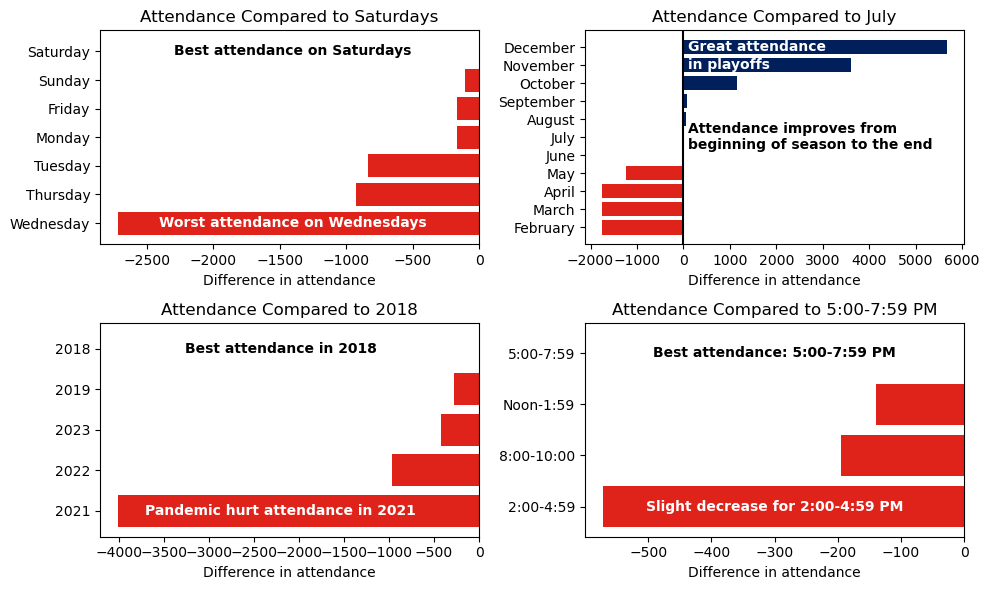

In [49]:
#Day, month, year, and kick off time feature importance
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,6))

# Day of the week
day_names = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
day_importance = [xgb_importance[key] for key in xgb_importance.keys() if 'day_' in key]

ax[0,0].barh(y=range(7),
             width=np.sort(day_importance),
             color=[mls_blue if x>=0 else mls_red for x in np.sort(day_importance)])
ax[0,0].set_yticks(range(7))
ax[0,0].set_yticklabels(day_names[x] for x in np.argsort(day_importance))
ax[0,0].set_title('Attendance Compared to Saturdays')
ax[0,0].set_xlabel('Difference in attendance')
ax[0,0].text(-1400,6,'Best attendance on Saturdays',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center')
ax[0,0].text(-1400,0,'Worst attendance on Wednesdays',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center',color='white')

# Month
month_names = ['February','March','April','May','June','July','August','September','October','November','December']
month_importance = [xgb_importance[key] for key in xgb_importance.keys() if 'date_month_' in key]

ax[0,1].barh(y=range(11),
             width=np.sort(month_importance),
             color=[mls_blue if x>=0 else mls_red for x in np.sort(month_importance)])
ax[0,1].set_yticks(range(11))
ax[0,1].set_yticklabels(month_names[x] for x in np.argsort(month_importance))
ax[0,1].axvline(0,color='black')
ax[0,1].set_title('Attendance Compared to July')
ax[0,1].set_xlabel('Difference in attendance')
ax[0,1].text(100,5,'Attendance improves from \nbeginning of season to the end',fontsize=10,fontweight='bold',
             horizontalalignment='left',verticalalignment='center')
ax[0,1].text(100,10,'Great attendance',fontsize=10,fontweight='bold',
             horizontalalignment='left',verticalalignment='center',color='white')
ax[0,1].text(100,9,'in playoffs',fontsize=10,fontweight='bold',
             horizontalalignment='left',verticalalignment='center',color='white')

# Year
year_names = ['2018','2019','2021','2022','2023']
year_importance = [xgb_importance[key] for key in xgb_importance.keys() if 'date_year_' in key]

ax[1,0].barh(y=range(5),
             width=np.sort(year_importance),
             color=[mls_blue if x>=0 else mls_red for x in np.sort(year_importance)])
ax[1,0].set_yticks(range(5))
ax[1,0].set_yticklabels(year_names[x] for x in np.argsort(year_importance))
ax[1,0].set_title('Attendance Compared to 2018')
ax[1,0].set_xlabel('Difference in attendance')
ax[1,0].text(-2200,4,'Best attendance in 2018',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center')
ax[1,0].text(-2200,0,'Pandemic hurt attendance in 2021',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center',color='white')

# Kick off time
kotime_names = ['Noon-1:59','2:00-4:59','5:00-7:59','8:00-10:00']
kotime_importance = [xgb_importance[key] for key in xgb_importance.keys() if 'time_categ_' in key]

ax[1,1].barh(y=range(4),
             width=np.sort(kotime_importance),
             color=[mls_blue if x>=0 else mls_red for x in np.sort(kotime_importance)])
ax[1,1].set_yticks(range(4))
ax[1,1].set_yticklabels(kotime_names[x] for x in np.argsort(kotime_importance))
ax[1,1].set_title('Attendance Compared to 5:00-7:59 PM')
ax[1,1].set_xlabel('Difference in attendance')
ax[1,1].text(-300,3,'Best attendance: 5:00-7:59 PM',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center')
ax[1,1].text(-300,0,'Slight decrease for 2:00-4:59 PM',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center',color='white')

fig.tight_layout();

**Day of the Week**: All the bars showing the change in attendance compared to matches on Saturdays (hence why there is no bar for Saturday). The most important trend here is that Wednesday matches get over 2,700 fewer people than an average Saturday match. To some extent, MLS has to play some midweek matches, but there are changes they can make to reduce the number of those matches.

**Month**: There is a clear trend that attendance tends to improve as the season progresses from February to December. The most likely reason for this is that matches become more important as the playoff picture becomes clearer and then the playoffs actually start in late October. The big takeaway for me is that people want to see matches where the stakes are high.

**Year**: The fact that 2021 got about 4,000 fewer people per match was mostly due to the pandemic.

**Kick Off Time**: The best time to kick off a match according to the model is between 5:00 pm and 7:59 pm. However, the change in attendance does not appear to be huge as the kick off time changes. In fact, the linear regression model found similar numbers, but they were not significant in that model.

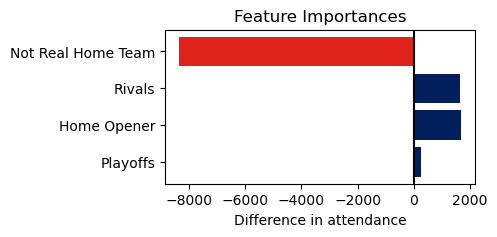

In [50]:
# Playoffs, home openers, rivals, and real home teams importance
fig, ax = plt.subplots(figsize=(4,2))

feat_importance = [xgb_importance[key] for key in xgb_importance.keys() if key in ['playoff',
                                                                                   'home_opener',
                                                                                   'rivals',
                                                                                   'real_home_team']]

feat_names = ['Playoffs','Home Opener','Rivals','Not Real Home Team']
ax.barh(y=range(4),
        width=feat_importance,
        color=[mls_blue if x>=0 else mls_red for x in feat_importance])
ax.axvline(0, color='black')
ax.set_title('Feature Importances')
ax.set_yticks(range(4))
ax.set_yticklabels(feat_names)
ax.set_xlabel('Difference in attendance');

**Not Real Home Team**: The biggest effect is not having a real home team in a match. When that happened, the average attendance is expected to be 8,000 lower than average, a huge decrease.

**Rivals**: When rivals play, the attendance is expected to go up about 2,000.

**Home Openers**: While February and March are predicted to have the worst attendance, home openers are predicted to have a significant boost in attendance, around 2,000.

**Playoffs**: This one is interesting because the model says that the attendance is not expected to go up because a match is a playoff match. However, I think this is wrong. Earlier, we saw that November and December had the highest predicted attendance. The thing that makes those months special is that the playoffs happen during those months. I think the reason the playoff parameter in the model has such a small effect is because that effect is already built in to the model through the month parameters.

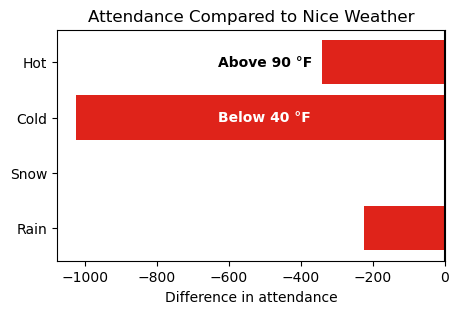

In [51]:
# Weather parameters
fig, ax = plt.subplots(figsize=(5,3))

feat_importance = [xgb_importance[key] for key in xgb_importance.keys() if key in ['rain_yn',
                                                                                   'snow_yn',
                                                                                   'cold',
                                                                                   'hot']]

feat_names = ['Rain','Snow','Cold','Hot']
ax.barh(y=range(4),
        width=feat_importance,
        color=[mls_blue if x>=0 else mls_red for x in feat_importance])

ax.axvline(0, color='black')
ax.set_title('Attendance Compared to Nice Weather')
ax.set_yticks(range(4))
ax.set_yticklabels(feat_names)
ax.set_xlabel('Difference in attendance')
ax.text(-500,3,'Above 90 \N{DEGREE SIGN}F',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center')
ax.text(-500,2,'Below 40 \N{DEGREE SIGN}F',fontsize=10,fontweight='bold',
             horizontalalignment='center',verticalalignment='center',color='white');

**Hot and cold weather**: According to the model, cold and hot temperatures don't seem to have a major effect. The model does say that cold weather (below 40 degrees Fahrenheit) is expected to get about 1,000 fewer people on average, but that is a smaller effect than many of the other factors.

**Rain and snow**: The model does not indicate there is much of an effect on attendance when it rains or snows. However, I think this might be mostly due to low sample size.

### Recommendations

**Weekends better than midweek**: The model indicated that matches played on Wednesdays get about 2,700 fewer fans than Saturday matches and Tuesdays/Thursdays get almost 1,000 fewer fans. Attendance would improve if MLS could play more of their matches on weekends rather than midweek.

It is impossible to avoid playing some midweek matches because there simply aren't enough weeks during the season for the teams to play all their matches on the weekend, but there are steps MLS can take to improve the situation. Currently, MLS teams also compete in a few other competitions: the US Open Cup, the CONCACAF Champions Cup, and the Leagues Cup. The latter two competitions are somewhat redundant since they are both competitions that include teams from other North American countries (the Champions Cup is all of North America while the Leagues Cup is an MLS vs. Liga MX competition). At least in 2023, a big reason teams had to play so many midweek matches is because the Leagues Cup forced MLS to pause its season for a full month. This wouldn't be such a problem if the Leagues Cup was well attended, but the average was just 17,257, significantly lower than MLS matches. Even worse, some teams were eliminated from the Leagues Cup after the first week, meaning they didn't play a match for about three weeks. I think MLS should reconsider the format of the Leagues Cup, particularly if it is worth it to pause MLS for such a long time. Without the Leagues Cup, MLS would have gotten back about 5 weekends.

**Make regular season matter**: The attendance improved from the beginning of the season to the end of the season. I think a big part of this trend is that matches become more intriguing as the playoffs approach because the stakes of each match get bigger. People want to watch matches that matter. The problem is that many fans feel like most of the regular season does not matter that much because so many teams make the playoffs, so a team does not actually have to perform that well to qualify. In most European leagues, a team has to finish with the best overall record to be crowned champion, but in MLS, over half of the teams qualify for the playoffs (in 2023, 18 teams out of 29 make the playoffs). Sporting Kansas City provides a great example of how low the bar is. In their first 10 matches, they got 0 wins, 3 ties, and 7 losses. This was the worst 10 match beginning to a season in history, and yet they recovered to make the playoffs, then proceeded to beat the 1-seed in the West, St. Louis FC. This shows that a team can perform quite poorly, but still make the playoffs. Then the team just needs to go on a hot streak to make a run in the playoffs.

The relative importance of regular season matches would increase if fewer teams made the playoffs, but this also comes with a downside. The fewer playoff spots there are, then the earlier teams will be eliminated from playoff contention. Once a team is unable to make the playoffs, their matches cease to matter.

I do have an idea for a compromise between number of teams making the playoffs and rewarding teams for finishing higher in the standings. In the Australian Football League (AFL), which plays Australian rules football, they have a format in which the top 8 teams make the playoffs, but the top 4 start with a pretty significant advantage (click this link for the exact details: https://en.wikipedia.org/wiki/AFL_final_eight_system). I think this format would do a good job of allowing enough teams into the playoffs while still rewarding the best-performing teams.

**Favor warmer cities in winter**: The model indicated that matches with temperatures below 40 degrees Fahrenheit had about 1,000 fewer fans on average. This seems to support the decision made by MLS to not play matches during most of the winter. The conditions would be even worse if MLS tried to hold matches in January and early February. Presumably, the attendance would also drop further.

MLS is forced to play some matches in February. Otherwise, they would not have enough time to actually play all of the matches they have scheduled. MLS could improve overall attendance by favoring warmer cities, meaning cities at lower latitude, during the first couple weeks of the year. This means playing February matches in places like Los Angeles, Houston, and Miami rather than places like Minnesota, New York, and Toronto.

Other considerations:

**Sharing stadium with NFL team**: The three teams with the highest overall attendance (Atlanta United, Seattle Sounders, and Charlotte FC) all share a stadium with an NFL team. Their advantage is pretty obvious: they have a larger stadium that they can utilize when demand is high. One argument against having a huge stadium is that the fan experience is not as fun when the stadium is less than half full, but this is not a big issue in my opinion. When there is not enough demand to fill the whole stadium, teams just sell tickets for the sections closest to the field, making for a similar environment as a smaller stadium.

While the top three teams in attendance indicate that having a larger stadium is better, it is not a guarantee of success. The Chicago Fire moved out of their smaller stadium in 2020 to move back into Soldier Field, which they share with the Chicago Bears of the NFL. The move has not led to a significant increase in attendance. This could possibly be due to the stadium being less easily accessible than the stadiums in Atlanta or Seattle or possibly just because the Fire have not been competitive for a long time.

I would not recommend that a team that already has their own stadium abandon it to move into a larger stadium. However, I do think this is an option that future expansion teams should explore. For example, if Phoenix or Las Vegas are awarded expansion teams, they should strongly consider using the stadiums owned by the Cardinals and Raiders of the NFL. They would have the potential for higher attendance and they would not have to pay to build a new stadium.

**Promote rivalries**: The model indicates that rivalry matches get about 2,000 more people on average. I think MLS would benefit from promoting these rivalries, but I would caution that they should not try to manufacture rivalries. Instead, they should make sure announcers and articles on their website highlight the history between teams. A good recent example of this is FC Cincinnati and the New York Red Bulls. They are not close enough geographically to be automatic rivals, but a rivalry was kindled when a player switched from Cincinnati to New York, leaving with some not so kind words for his former club. These are the kinds of things that can spark animosity between fanbases.

Text(50, 5, 'This data not \nused to train model')

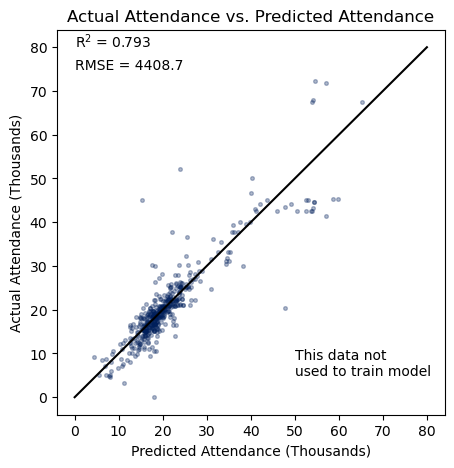

In [52]:
# Remake plot of actual attendance vs. predicted attendance for presentation
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(xgb_best.predict(X_test)/1000,
           y_test/1000,
           s=7,
           alpha=0.3,
           color=mls_blue)
ax.plot([0,80],[0,80], color='black')
ax.set_title('Actual Attendance vs. Predicted Attendance')
ax.set_xlabel('Predicted Attendance (Thousands)')
ax.set_ylabel('Actual Attendance (Thousands)')
ax.text(0,80,f"R$^2$ = {np.round(r2_score(y_test, xgb_best.predict(X_test)),3)}")
ax.text(0,75,f"RMSE = {np.round(mse(y_test, xgb_best.predict(X_test), squared=False),1)}")
ax.text(50,5,'This data not \nused to train model')